### Pacakges

In [ ]:
# !pip install psycopg2
# !pip install "snowflake-connector-python[pandas]"
# !pip install lightgbm
# !pip install gtfs-realtime-bindings
# !pip install snowflake-connector-python[secure-local-storage]
# !pip install xgboost
# !pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import requests
import holidays
import warnings
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
import shap
import snowflake.connector
from statsmodels.stats.outliers_influence import variance_inflation_factor
import lightgbm as lgb
import xgboost as xgb

### Data

In [ ]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user='SPARK',
    authenticator = "externalbrowser",
    account='XXX',  # e.g., xy12345.us-east-1
    warehouse='XXX',
    database='XXX',
    schema='XXX',
    role = "XXX"
)
cursor = conn.cursor()
# Explicitly activate the warehouse
cursor.execute('USE WAREHOUSE "XXX"')

# Query data
query = "SELECT * FROM XXX XXXX'"
cursor.execute(query)

# Convert to pandas DataFrame
df = cursor.fetch_pandas_all()

# Close the connection
cursor.close()
conn.close()

# Display results
print(df.head())

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://bseglobal.okta.com/app/snowflake/exkqh96ogn06lUM3g4x7/sso/saml?SAMLRequest=rZPNbuIwFIVfJfKsEztA09YCKqaIFol2UBMqDTsnMcETxw6%2BTgNvPw5%2F6iza1ews%2B1x%2F595jDx%2F2lfQ%2BuAGh1QiFAUEeV5nOhSpGaJXM%2FDvkgWUqZ1IrPkIHDuhhPARWyZpOGrtVb3zXcLCeu0gB7Q5GqDGKagYCqGIVB2ozGk9eFrQXEMoAuLEOh84lOQjH2lpbU4zbtg3afqBNgXuEEEzusVN1kh%2FoE6L%2BnlEbbXWm5aVk73r6AhFiMugQTuEIy3PhT6FOI%2FiOkp5EQJ%2BTZOkvf8UJ8iaX7h61gqbiJubmQ2R89bY4GQDnIDVal%2FKgoNbGghsuV9ZVMaEqt%2FJT4IXUKZMBKN1uJCt5pqu6sQ4WuBXe8BxLXQg3wvl0hOpS5LP3baKidFFUIV%2FHa%2FY7eR1Em%2FQp%2FtOCMDbcERs%2FR%2B02fioz5L1fAu91gc8BGj5XXczWbZHejU%2Fu%2FLCfhHd0ENKbKLgd9NbIm7qYhWL2WHnt5WpWl5Yd7bG6xlfnmO%2FL3fY%2B0oUikVy99IvB%2FhYDaNzliE5PiR4tmPF%2FGtAQf770%2FFhfXX7z6VJLkR28mTYVs1%2FHGwbhcUfk%2FuYopbxiQk7y3HAAF7OUun00

In [ ]:
# Convert all column names to lowercase
df.columns = df.columns.str.lower()

In [ ]:
df.columns

Index(['event_name', 'event_name_long', 'season_name', 'season_year',
       'event_date', 'event_time', 'event_day', 'team', 'event_type',
       'minor_category', 'property', 'waittime date', 'date read time',
       'sensordesc', 'numberinline', 'servetimeframes', 'starttime',
       'serve time (seconds)', 'relative start (minutes)', 'event_time_1',
       'wait time (seconds)', 'wait time (minutes)', 'time category'],
      dtype='object')

In [ ]:
# Filter for Barclays
df = df[df['property'] == 'Barclays']

In [ ]:
# Needed columns
needed_columns = ['event_name',
'event_name_long',
'event_date',
'event_time',
'event_day',
'starttime',
'team',
'minor_category',
'property',
'numberinline',
'relative start (minutes)',
'wait time (minutes)',
'time category']

df = df[needed_columns]

#### Clean

In [ ]:
# Convert times
df['event_date'] = pd.to_datetime(df['event_date'])
df['starttime'] = pd.to_datetime(df['starttime'], errors='coerce')
df['event_time'] = pd.to_datetime(df['event_time'], format='%H:%M:%S').dt.time

In [ ]:
df['event_date'].min()

Timestamp('2023-09-22 00:00:00')

In [ ]:
df['event_date'].max()

Timestamp('2025-07-18 00:00:00')

In [ ]:
# Remove upsell or irrelevant events
df = df[~(df['event_name_long'].str.contains("Upsell", na=False) |
          df['event_name_long'].str.contains("CANCELED", na=False) |
          df['event_name_long'].str.contains("Cancelled", na=False) |
          df['event_name_long'].str.contains("Libs for Kids 2023 Holding Event", na=False) |
          df['event_name_long'].str.contains("Test", na=False) |
          df['team'].str.contains("Test", case=False, na=False))]

# Drop nulls in critical columns
df = df.dropna(subset=['relative start (minutes)', 'wait time (minutes)', 'numberinline'])

#### Cut

In [ ]:
# Minimum and maximum event_date
print('Minimum event_date:', df['event_date'].min())
print('Maximum event_date:', df['event_date'].max())

Minimum event_date: 2023-09-22 00:00:00
Maximum event_date: 2025-07-18 00:00:00


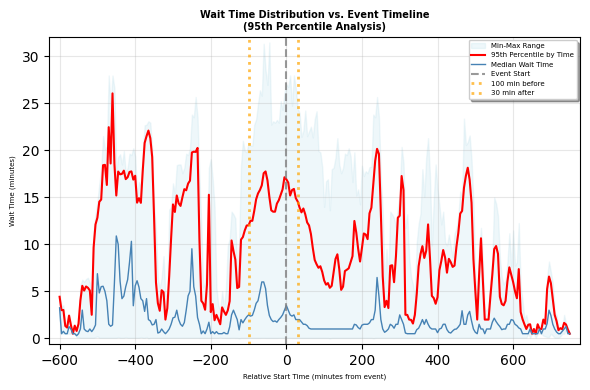

In [ ]:
# Group data by relative start time and calculate statistics
bin_size = 5  # 5-minute bins
df['time_bin'] = (df['relative start (minutes)'] // bin_size) * bin_size

# Calculate statistics per time bin
stats_by_time = df.groupby('time_bin')['wait time (minutes)'].agg([
    'min', 'max', 'mean', 'median',
    lambda x: np.percentile(x, 95)
]).rename(columns={'<lambda_0>': 'p95'}).reset_index()


plt.figure(figsize=(6, 4))
plt.fill_between(stats_by_time['time_bin'],
                stats_by_time['min'],
                stats_by_time['max'],
                alpha=0.2, color='lightblue', label='Min-Max Range')

# Plot the 95th percentile line in red
plt.plot(stats_by_time['time_bin'], stats_by_time['p95'],
         color='red', linewidth=1.5, label='95th Percentile by Time')

# Plot the median line for reference
plt.plot(stats_by_time['time_bin'], stats_by_time['median'],
         color='steelblue', linewidth=1, linestyle='-', label='Median Wait Time')

# Add reference lines for event timing
plt.axvline(0, linestyle='--', color='gray', linewidth=1.5,
           label='Event Start', alpha=0.8)
plt.axvline(-100, linestyle=':', color='orange', linewidth=2,
           label='100 min before', alpha=0.7)
plt.axvline(30, linestyle=':', color='orange', linewidth=2,
           label='30 min after', alpha=0.7)

plt.title("Wait Time Distribution vs. Event Timeline\n(95th Percentile Analysis)",
          fontsize=7, fontweight='bold', pad=5)
plt.xlabel("Relative Start Time (minutes from event)", fontsize=5)
plt.ylabel("Wait Time (minutes)", fontsize=5)
plt.grid(True, alpha=0.3, linestyle='-')
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True,
          fontsize=5)

# Set axis limits with some padding
plt.margins(0.02)
plt.tight_layout()
plt.show()


In [ ]:
# Round to nearest minute
df['relative start (minutes)'].astype(int)

# Filter out after-event tail if not useful
df = df[df['relative start (minutes)'] <= 30] # Operataional cutoff
df = df[df['relative start (minutes)'] >= -100]

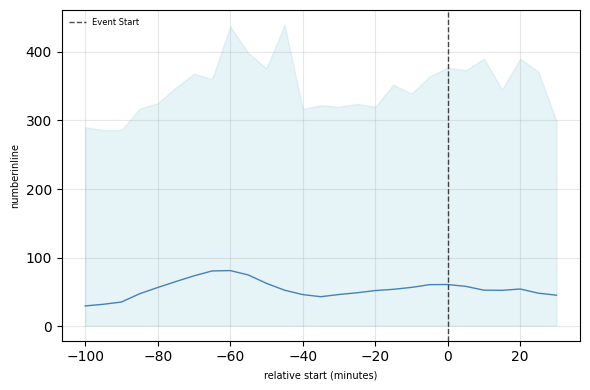

In [ ]:
# Numberinline
stats_by_time = df.groupby('time_bin')['numberinline'].agg([
    'min', 'max', 'mean'
]).reset_index()

plt.figure(figsize=(6,4))
plt.fill_between(stats_by_time['time_bin'],
                stats_by_time['min'],
                stats_by_time['max'],
                alpha=0.3, color='lightblue')

# Plot the main line (mean)
plt.plot(stats_by_time['time_bin'], stats_by_time['mean'],
         color='steelblue', linewidth=1)

# Add event start reference line
plt.axvline(0, linestyle='--', color='black', linewidth=1,
           label='Event Start', alpha=0.7)

# Clean styling
plt.xlabel('relative start (minutes)', fontsize=7)
plt.ylabel('numberinline', fontsize=7)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', frameon=False, fontsize = 6)

plt.tight_layout()
plt.show()

#### Attendance

In [ ]:
# Attendence counts
def run_query():
#Connect with the database
    DW_HOST = "XXX"
    DW_PORT = "XXX"
    DW_USER = "XXX"
    DW_PASS = "XXX"
    DW_BSEDW_DATABASE = "XXX"
    #Use psycopg2 for interacting with PostgreSQL from the Python scripting language.
    connection = psycopg2.connect(
            user = DW_USER,
            password = DW_PASS,
            host = DW_HOST,
            port = DW_PORT,
            database = DW_BSEDW_DATABASE
    )
#Edit your query below (between the ''' and '''):

    query = '''
 SELECT event_date, event_time, count (*)
        FROM XXX
        WHERE
            result_code_desc = 'Initial Entry'
        group by 1, 2
    '''
    test = pd.read_sql(query, con = connection)

    return(test)

run_query()
attendance = run_query()
print(attendance)

C:\Users\spark\AppData\Local\Temp\ipykernel_12644\2998683415.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test = pd.read_sql(query, con = connection)


    event_date event_time  count
0   2023-03-13   20:00:00      5
1   2023-03-17   17:30:00   3131
2   2023-04-01   20:00:00  10986
3   2023-05-05   19:00:00   5158
4   2023-05-06   11:00:00    309
..         ...        ...    ...
470 2025-07-29   19:30:00  15537
471 2025-07-31   20:00:00   9553
472 2025-08-04   19:30:00  11945
473 2025-08-05   19:00:00  16411
474 2025-08-10   12:30:00  15402

[475 rows x 3 columns]


In [ ]:
# Fix attendance event_date and time type
attendance['event_date'] = pd.to_datetime(attendance['event_date'])
if isinstance(attendance['event_time'].iloc[0], str):
    attendance['event_time'] = pd.to_datetime(attendance['event_time']).dt.time
elif isinstance(attendance['event_time'].iloc[0], pd.Timestamp):
    attendance['event_time'] = attendance['event_time'].dt.time

C:\Users\spark\AppData\Local\Temp\ipykernel_12644\1336832239.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  attendance['event_time'] = pd.to_datetime(attendance['event_time']).dt.time


In [ ]:
# Merging data
df_merged = pd.merge(df, attendance, on=['event_date', 'event_time'], how='left', suffixes=('', '_attendance'))
attendance_matches = df_merged['count'].notna().sum()
print(f"After attendance merge shape: {df_merged.shape}")
print(f"Attendance matches: {attendance_matches} out of {len(df_merged)} records ({attendance_matches/len(df_merged)*100:.1f}%)")
print("After attendance merge columns:", df_merged.columns.tolist())

# Update the main df variable
df = df_merged.copy()
print("Final df shape:", df.shape)
print("Final df columns:", df.columns.tolist())
print(f"Records with both attendance and category data: {((df['count'].notna()) & (df['minor_category'].notna())).sum()}")
print("\nSample of final df:")
print(df[['event_date', 'event_time', 'event_day', 'count']].head())

After attendance merge shape: (123519, 15)
Attendance matches: 123519 out of 123519 records (100.0%)
After attendance merge columns: ['event_name', 'event_name_long', 'event_date', 'event_time', 'event_day', 'starttime', 'team', 'minor_category', 'property', 'numberinline', 'relative start (minutes)', 'wait time (minutes)', 'time category', 'time_bin', 'count']
Final df shape: (123519, 15)
Final df columns: ['event_name', 'event_name_long', 'event_date', 'event_time', 'event_day', 'starttime', 'team', 'minor_category', 'property', 'numberinline', 'relative start (minutes)', 'wait time (minutes)', 'time category', 'time_bin', 'count']
Records with both attendance and category data: 123519

Sample of final df:
  event_date event_time event_day  count
0 2024-11-07   20:00:00       THU   9785
1 2024-11-06   19:00:00       WED   5841
2 2024-11-07   20:00:00       THU   9785
3 2025-01-18   19:00:00       SAT   4466
4 2024-11-06   19:00:00       WED   5841


#### Weather

In [ ]:
# Define parameters for historical weather data
latitude = 40.684908   # Barclays Center
longitude = -73.977862
start_date = str(df['event_date'].min().date())
end_date = str(df['event_date'].max().date())

# API Endpoint
url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone=auto"

# Make request
response = requests.get(url)
data = response.json()

# Convert to DataFrame
weather = pd.DataFrame(data["daily"])
weather["time"] = pd.to_datetime(weather["time"])  # Convert time to datetime format

weather = weather.rename(columns={'time': 'event_date'})

In [ ]:
df_with_weather = df.merge(weather, on = 'event_date', how = 'left')

### Features

#### Queue

In [ ]:
# Adding queue trend features (when lines are accelearating or decelerating)
df = df.sort_values(['event_name','relative start (minutes)'])

# 3-minute rolling mean -- congestion at specific times
df['queue_mean_3'] = (
    df.groupby('event_name')['numberinline']
      .transform(lambda s: s.rolling(window=3, min_periods=1).mean())
)

df['day_of_week'] = df['event_date'].dt.dayofweek

# 3-minute rolling slope (simple linear trend) -- accelration or deceleration of queue
def _slope(a):
    idx = np.arange(len(a))
    return np.polyfit(idx, a, 1)[0]  # coefficient of x

df['queue_slope_3'] = (
    df.groupby('event_name')['numberinline']
      .transform(lambda s: s.rolling(window=3, min_periods=2).apply(_slope, raw=True))
      .fillna(0)
)

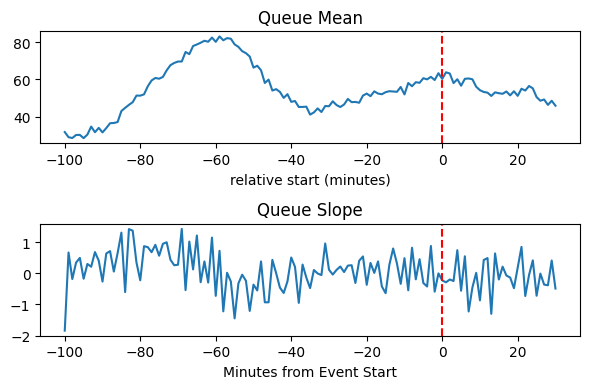

In [ ]:
# Combined plot
plt.figure(figsize=(6, 4))
plt.subplot(2,1,1)
df.groupby('relative start (minutes)')['queue_mean_3'].mean().plot()
plt.title('Queue Mean')
plt.axvline(0, color='red', linestyle='--')

plt.subplot(2,1,2)
df.groupby('relative start (minutes)')['queue_slope_3'].mean().plot()
plt.title('Queue Slope')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Minutes from Event Start')

plt.tight_layout()
plt.show()

#### Cyclical

In [ ]:
# Cyclical time features
df['hour'] = pd.to_datetime(df['event_time'], format='%H:%M:%S').dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)

# Day of week cyclical encoding
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)

# Minute bucket cyclical encoding (for within-event timing)
df['minute_sin'] = np.sin(2 * np.pi * df['relative start (minutes)'] / 30)  # 30 minute cycle

# Weekend boolean
df['is_weekend'] = np.where(df['event_day'].isin(['SAT', 'SUN']), 1, 0)

#### Interaction

In [ ]:
# Interaction features
df['minute_minor_interaction'] = df['relative start (minutes)'] * df['minor_category'].astype('category').cat.codes
df['minute_sq'] = df['relative start (minutes)']**2
df['numberinline_log'] = np.log1p(df['numberinline'])

In [ ]:
# past 10 minutes, peak 3 minute average
# Event-level intensity proxies =
df['log_queue_max10'] = (
    df.groupby('event_name')['queue_mean_3']
      .transform(lambda s: np.log1p(s.rolling(10, 1).max()))
)

#### Holiday

In [ ]:
# Dates to align
min_date = df['event_date'].min()
max_date = df['event_date'].max()

date_range = pd.date_range(start=min_date, end=max_date)

# Get U.S. federal holidays
us_holidays = holidays.UnitedStates(years=[2023, 2024, 2025])

# Create boolean column
df_holiday = pd.DataFrame({'date': date_range})
df_holiday['is_holiday'] = df_holiday['date'].isin(us_holidays)

# Holiday name
df_holiday['holiday_name'] = df_holiday['date'].map(us_holidays)
df_holiday['holiday_name'] = df_holiday['holiday_name'].fillna("No Holiday")

print(df.head(20))

       event_name event_name_long event_date event_time event_day  \
45236    23BA0922        Arcangel 2023-09-22   20:00:00       FRI   
60723    23BA0922        Arcangel 2023-09-22   20:00:00       FRI   
76050    23BA0922        Arcangel 2023-09-22   20:00:00       FRI   
122322   23BA0922        Arcangel 2023-09-22   20:00:00       FRI   
45237    23BA0922        Arcangel 2023-09-22   20:00:00       FRI   
14207    23BA0922        Arcangel 2023-09-22   20:00:00       FRI   
76051    23BA0922        Arcangel 2023-09-22   20:00:00       FRI   
14208    23BA0922        Arcangel 2023-09-22   20:00:00       FRI   
14209    23BA0922        Arcangel 2023-09-22   20:00:00       FRI   
106718   23BA0922        Arcangel 2023-09-22   20:00:00       FRI   
91397    23BA0922        Arcangel 2023-09-22   20:00:00       FRI   
45238    23BA0922        Arcangel 2023-09-22   20:00:00       FRI   
45239    23BA0922        Arcangel 2023-09-22   20:00:00       FRI   
45240    23BA0922        Arcangel 

C:\Users\spark\AppData\Local\Temp\ipykernel_12644\2468593260.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_holiday['is_holiday'] = df_holiday['date'].isin(us_holidays)


In [ ]:
# Change date name
df_holiday = df_holiday.rename(columns={'date': 'event_date'})
df_holiday['event_date'] = pd.to_datetime(df_holiday['event_date'])

In [ ]:
# Merge
df = df.merge(df_holiday, on='event_date', how='left')

#### Historical

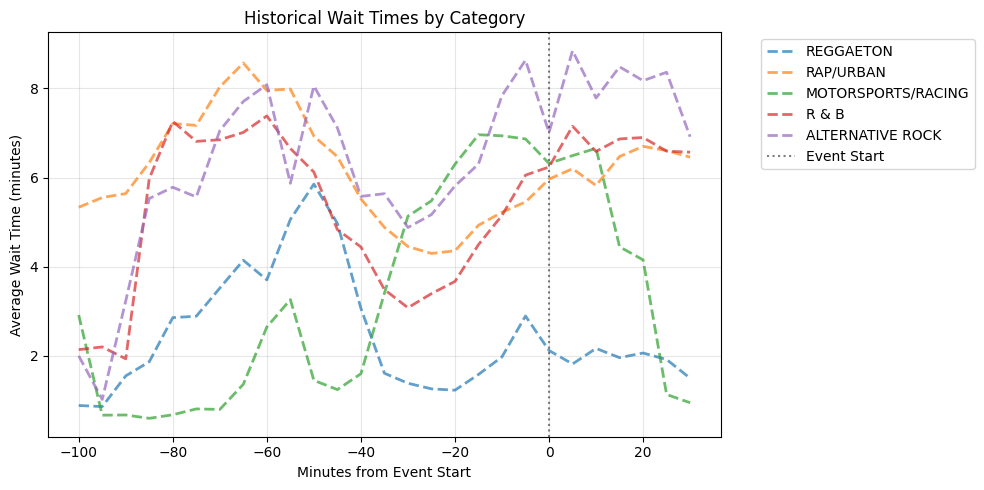

In [ ]:
# Simple historical vs actual comparison by category and time
category_time_avg = df.groupby(['minor_category', 'time_bin'])['wait time (minutes)'].mean().reset_index()
category_time_avg = category_time_avg.rename(columns={'wait time (minutes)': 'historical_avg'})
df_plot = df.merge(category_time_avg, on=['minor_category', 'time_bin'], how='left')

plt.figure(figsize=(10,5))
for category in df['minor_category'].unique()[:5]:  # Top 5 categories
   cat_data = df_plot[df_plot['minor_category'] == category].groupby('time_bin').agg({
       'wait time (minutes)': 'mean',
       'historical_avg': 'first'
   }).reset_index()
   plt.plot(cat_data['time_bin'], cat_data['historical_avg'], '--', label=f'{category}', linewidth=2, alpha=0.7)

plt.axvline(0, color='black', linestyle=':', alpha=0.5, label='Event Start')
plt.xlabel('Minutes from Event Start')
plt.ylabel('Average Wait Time (minutes)')
plt.title('Historical Wait Times by Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

category_time_avg.head()



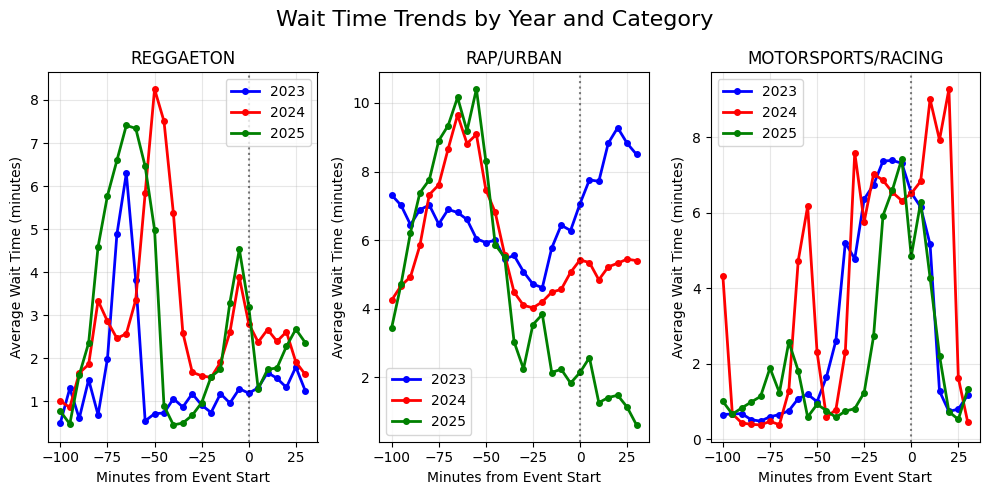

Year-over-year changes by category:

REGGAETON:
  2023: 1.5 min avg (909 records)
  2024: 3.1 min avg (1379 records)
  2025: 2.7 min avg (200 records)

RAP/URBAN:
  2023: 6.7 min avg (9291 records)
  2024: 5.9 min avg (14214 records)
  2025: 5.1 min avg (591 records)

MOTORSPORTS/RACING:
  2023: 4.0 min avg (1611 records)
  2024: 5.3 min avg (1428 records)
  2025: 2.6 min avg (546 records)


In [ ]:
# Historical vs actual by year and category
df['time_bin'] = (df['relative start (minutes)'] // 5) * 5
df['year'] = df['event_date'].dt.year

plt.figure(figsize=(10, 5))
colors = ['blue', 'red', 'green', 'orange', 'purple']
years = sorted(df['year'].unique())

for i, category in enumerate(df['minor_category'].unique()[:3]):  # Top 3 categories
   plt.subplot(1, 3, i+1)

   for j, year in enumerate(years):
       year_cat_data = df[(df['minor_category'] == category) & (df['year'] == year)]
       if len(year_cat_data) > 0:
           yearly_avg = year_cat_data.groupby('time_bin')['wait time (minutes)'].mean().reset_index()
           plt.plot(yearly_avg['time_bin'], yearly_avg['wait time (minutes)'],
                   '-', color=colors[j % len(colors)], label=f'{year}', linewidth=2, marker='o', markersize=4)

   plt.axvline(0, color='black', linestyle=':', alpha=0.5)
   plt.xlabel('Minutes from Event Start')
   plt.ylabel('Average Wait Time (minutes)')
   plt.title(f'{category}')
   plt.legend()
   plt.grid(True, alpha=0.3)

plt.suptitle('Wait Time Trends by Year and Category', fontsize=16)
plt.tight_layout()
plt.show()

# Summary statistics
print("Year-over-year changes by category:")
for category in df['minor_category'].unique()[:3]:
   print(f"\n{category}:")
   for year in years:
       avg_wait = df[(df['minor_category'] == category) & (df['year'] == year)]['wait time (minutes)'].mean()
       count = len(df[(df['minor_category'] == category) & (df['year'] == year)])
       print(f"  {year}: {avg_wait:.1f} min avg ({count} records)")

In [ ]:
df.groupby(['minor_category', 'time_bin'])['numberinline'].mean()

minor_category    time_bin
ALTERNATIVE ROCK  -100         4.000000
                  -95          2.045455
                  -90         36.433962
                  -85         73.666667
                  -80         70.223881
                                ...    
WRESTLING          10         50.348148
                   15         50.173554
                   20         33.256198
                   25          9.522388
                   30          4.678571
Name: numberinline, Length: 754, dtype: float64

In [ ]:
# Historical Average Queue Length by Category & Time
historical_queue_category = df.groupby(['minor_category', 'relative start (minutes)'])['numberinline'].agg([
    'mean', 'std', 'count'
]).round(2)
historical_queue_category.columns = ['hist_avg_queue_cat', 'hist_std_queue_cat', 'hist_count_queue']
historical_queue_category = historical_queue_category.reset_index()

In [ ]:
# Historical Queue Growth Patterns (replacing queue_slope_3)
df_sorted = df.sort_values(['event_name', 'relative start (minutes)'])
df_sorted['queue_change'] = df_sorted.groupby('event_name')['numberinline'].diff().fillna(0)

historical_queue_growth = df_sorted.groupby(['minor_category', 'relative start (minutes)'])['queue_change'].agg([
    'mean', 'std'
]).round(2)
historical_queue_growth.columns = ['hist_avg_queue_growth', 'hist_std_queue_growth']
historical_queue_growth = historical_queue_growth.reset_index()

In [ ]:
# Historical Queue Intensity (replacing log_queue_max10)
queue_intensity = df.groupby('event_name')['numberinline'].max().reset_index()
queue_intensity = queue_intensity.rename(columns={'numberinline': 'event_max_queue'})
df_with_intensity = df.merge(queue_intensity, on='event_name', how='left')

historical_intensity = df_with_intensity.groupby(['minor_category', 'relative start (minutes)'])['event_max_queue'].agg([
    'mean', 'std'
]).round(2)
historical_intensity.columns = ['hist_avg_intensity', 'hist_std_intensity']

In [ ]:
df = df.merge(historical_queue_category, on=['minor_category', 'relative start (minutes)'], how='left')
df = df.merge(historical_queue_growth, on=['minor_category', 'relative start (minutes)'], how='left')
df = df.merge(historical_intensity, on=['minor_category', 'relative start (minutes)'], how='left')

In [ ]:
# df = pd.read_csv('df.csv')

In [ ]:
df.columns

Index(['event_name', 'event_name_long', 'event_date', 'event_time',
       'event_day', 'starttime', 'team', 'minor_category', 'property',
       'numberinline', 'relative start (minutes)', 'wait time (minutes)',
       'time category', 'time_bin', 'count', 'queue_mean_3', 'day_of_week',
       'queue_slope_3', 'hour', 'hour_sin', 'day_sin', 'minute_sin',
       'is_weekend', 'minute_minor_interaction', 'minute_sq',
       'numberinline_log', 'log_queue_max10', 'is_holiday', 'holiday_name',
       'minute_bin', 'year', 'hist_avg_queue_cat_x', 'hist_std_queue_cat_x',
       'hist_count_queue_x', 'hist_avg_queue_cat_y', 'hist_std_queue_cat_y',
       'hist_count_queue_y', 'hist_avg_queue_cat', 'hist_std_queue_cat',
       'hist_count_queue', 'hist_avg_queue_growth', 'hist_std_queue_growth',
       'hist_avg_intensity', 'hist_std_intensity'],
      dtype='object')

### Modeling

In [ ]:
columns_for_model = [
        'event_name', 'event_date', 'relative start (minutes)',
        'event_day', 'team', 'minor_category', 'time category',
        'is_weekend', 'is_holiday', 'queue_slope_3', 'hour_sin', 'day_sin',
        'minute_sin', 'count', 'tier', 'temperature_2m_max', 'precipitation_sum',
        'minute_category_interaction', 'minute_squared',
        'log_queue_max10', 'numberinline_log', 'hist_avg_queue_cat', 'hist_std_queue_cat',
        'hist_count_queue', 'hist_avg_queue_growth', 'hist_std_queue_growth', 'hist_avg_intensity', 'hist_std_intensity'
    ]
target = 'wait time (minutes)'

In [ ]:
# Filter available columns
available_columns = [col for col in columns_for_model if col in df.columns]
df_model = df[available_columns + [target]].copy()

In [ ]:
# Remove records with missing target
df_model = df_model.dropna(subset=[target])

In [ ]:
# Features for modeling (excluding identifiers)
features = [col for col in available_columns if col not in ['event_name', 'event_date']]

In [ ]:
# Analyze outlier patterns before removal
print("Wait time distribution analysis:")
print(f"95th percentile: {df_model[target].quantile(0.95):.1f} minutes")
print(f"99th percentile: {df_model[target].quantile(0.99):.1f} minutes")
print(f"Maximum: {df_model[target].max():.1f} minutes")

Wait time distribution analysis:
95th percentile: 15.4 minutes
99th percentile: 20.9 minutes
Maximum: 31.5 minutes


In [ ]:
# Outlier removal for 95th percentile modeling
Q1 = df_model[target].quantile(0.05)  # Use 5th percentile instead of 25th
Q99 = df_model[target].quantile(0.99)  # Use 99th percentile instead of 75th

outliers_before = len(df_model)
df_model = df_model[(df_model[target] >= Q1) & (df_model[target] <= Q99)]
outliers_removed = outliers_before - len(df_model)

outliers_removed = outliers_removed
print(f"{outliers_removed/outliers_before*100:.1f}%")

5.3%


#### Train Test

In [ ]:
X = df_model[features]
y = df_model[target]

# Group-based split to ensure events don't overlap
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df_model['event_name']))

n_train_events = len(df_model.iloc[train_idx]['event_name'].unique())
n_test_events = len(df_model.iloc[test_idx]['event_name'].unique())

print(f"Train: {len(train_idx)} records from {n_train_events} events")
print(f"Test:  {len(test_idx)} records from {n_test_events} events")

# Final check for NaN values
X_clean = X.copy()
y_clean = y.copy()

# Fill remaining missing values
numeric_columns = X_clean.select_dtypes(include=[np.number]).columns
X_clean[numeric_columns] = X_clean[numeric_columns].fillna(X_clean[numeric_columns].median())

categorical_columns = X_clean.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X_clean[col] = X_clean[col].fillna('unknown')

print(f"Data cleaned - X shape: {X_clean.shape}, y shape: {y_clean.shape}")
print(f"Missing values in X: {X_clean.isna().sum().sum()}")
print(f"Missing values in y: {y_clean.isna().sum()}")

Train: 95565 records from 156 events
Test:  21402 records from 39 events
Data cleaned - X shape: (116967, 21), y shape: (116967,)
Missing values in X: 0
Missing values in y: 0


#### Multicollinearity

In [ ]:
if 'X_clean' in locals():
    # Select numeric features only for VIF analysis
    numeric_X = X_clean.select_dtypes(include=[np.number])

    if len(numeric_X.columns) > 1:
        # Scale features first
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(numeric_X)

        # Calculate VIF
        vif_data = pd.DataFrame()
        vif_data["feature"] = numeric_X.columns
        vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

        print("Variance Inflation Factors:")
        print(vif_data.sort_values(by="VIF", ascending=False))

        high_vif = vif_data[vif_data["VIF"] > 5]
        if not high_vif.empty:
            print(f"\n High multicollinearity detected in {len(high_vif)} features")
        else:
            print("\n No significant multicollinearity detected")
    else:
        print("Not enough numeric features for VIF analysis")
else:
    print("VIF analysis skipped (statsmodels not available or data not ready)")


Variance Inflation Factors:
                     feature       VIF
10        hist_std_queue_cat  6.296684
13     hist_std_queue_growth  4.749578
9         hist_avg_queue_cat  3.936665
1                 is_weekend  3.031207
4                    day_sin  2.933675
8           numberinline_log  2.389943
7            log_queue_max10  2.319946
11          hist_count_queue  1.868097
14        hist_avg_intensity  1.763026
15        hist_std_intensity  1.698406
2              queue_slope_3  1.641365
6                      count  1.639582
3                   hour_sin  1.279936
0   relative start (minutes)  1.194044
5                 minute_sin  1.007939
12     hist_avg_queue_growth  1.004856

 High multicollinearity detected in 1 features


#### Preprocess

In [ ]:
if 'X_clean' in locals():
    # Identify categorical and numerical features
    categorical_features = [col for col in features if X_clean[col].dtype == 'object']
    numerical_features = [col for col in features if col not in categorical_features]

    print(f"Categorical features: {len(categorical_features)}")
    print(f"Numerical features: {len(numerical_features)}")

    # Training data
    df_train = df_model.iloc[train_idx].copy()
    df_test = df_model.iloc[test_idx].copy()

    # Create category mappings for consistent encoding
    category_levels = {col: sorted(df_train[col].dropna().unique()) for col in categorical_features}

    # Create preprocessor
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(
            drop='first',
            handle_unknown='ignore',
            categories=[category_levels[col] for col in categorical_features]
        ), categorical_features)
    ])

    # Fit preprocessor on training data
    preprocessor.fit(df_train[features])

    # Transform features
    X_train = preprocessor.transform(df_train[features])
    X_test = preprocessor.transform(df_test[features])
    y_train = df_train[target].values
    y_test = df_test[target].values

    # Get feature names after preprocessing
    feature_names = preprocessor.get_feature_names_out()

    print(f"Final feature count: {len(feature_names)}")
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")

Categorical features: 4
Numerical features: 10
Final feature count: 158
Training data shape: (95565, 158)
Test data shape: (21402, 158)


c:\Users\spark\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Single Model Train

In [ ]:
if 'X_train' in locals():
    # Convert sparse matrices to dense if needed
    if hasattr(X_train, 'toarray'):
        X_train_dense = X_train.toarray()
        X_test_dense = X_test.toarray()
    else:
        X_train_dense = X_train
        X_test_dense = X_test

    single_models = {}
    single_predictions = {}

    # Gradient Boosting Quantile Regressor
    print("Training Gradient Boosting...")
    gb_single = GradientBoostingRegressor(
        loss='quantile',
        alpha=0.95,
        n_estimators=100,
        max_depth=6,
        random_state=42
    )
    gb_single.fit(X_train_dense, y_train)
    gb_pred_single = gb_single.predict(X_test_dense)

    single_models['gradient_boosting'] = gb_single
    single_predictions['gradient_boosting'] = gb_pred_single

    # LightGBM
    print("Training LightGBM...")
    lgb_single = lgb.LGBMRegressor(
        objective='quantile',
        alpha=0.95,
        n_estimators=100,
        max_depth=6,
        random_state=42,
        verbosity=-1
    )
    lgb_single.fit(X_train_dense, y_train)
    lgb_pred_single = lgb_single.predict(X_test_dense)

    single_models['lightgbm'] = lgb_single
    single_predictions['lightgbm'] = lgb_pred_single

    # XGBoost
    print("Training XGBoost...")
    xgb_single = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=0.95,
        n_estimators=100,
        max_depth=6,
        random_state=42,
        verbosity=0
    )
    xgb_single.fit(X_train_dense, y_train)
    xgb_pred_single = xgb_single.predict(X_test_dense)

    single_models['xgboost'] = xgb_single
    single_predictions['xgboost'] = xgb_pred_single

    print(f" Trained {len(single_models)} single models")

Training Gradient Boosting...
Training LightGBM...


c:\Users\spark\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\spark\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training XGBoost...
 Trained 3 single models


#### Multi-Minute Bucket Model Train

In [ ]:
if 'X_train' in locals():
    multi_models = {}
    multi_predictions = {}

    def train_multi_minute_model(model_type, quantile=0.95):
        """Train separate models for each minute bucket"""
        models_by_minute = {}
        minute_buckets = df_train['relative start (minutes)'].unique()

        for minute_bucket in sorted(minute_buckets):
            bucket_mask = df_train['relative start (minutes)'] == minute_bucket

            if bucket_mask.sum() < 5:  # Skip buckets with too few samples
                continue

            X_bucket = X_train_dense[bucket_mask]
            y_bucket = y_train[bucket_mask]

            # Create model based on type
            if model_type == 'gradient_boosting':
                model = GradientBoostingRegressor(
                    loss='quantile',
                    alpha=quantile,
                    n_estimators=100,
                    max_depth=6,
                    random_state=42
                )
            elif model_type == 'lightgbm':
                model = lgb.LGBMRegressor(
                    objective='quantile',
                    alpha=quantile,
                    n_estimators=100,
                    max_depth=6,
                    random_state=42,
                    verbosity=-1
                )
            elif model_type == 'xgboost':
                model = xgb.XGBRegressor(
                    objective='reg:quantileerror',
                    quantile_alpha=quantile,
                    n_estimators=100,
                    max_depth=6,
                    random_state=42,
                    verbosity=0
                )
            else:
                continue

            model.fit(X_bucket, y_bucket)
            models_by_minute[minute_bucket] = model

        return models_by_minute

    def predict_multi_minute(models_by_minute, df_test, X_test_dense):
        """Make predictions using appropriate minute bucket models"""
        predictions = np.full(len(df_test), np.nan)

        for i, (idx, row) in enumerate(df_test.iterrows()):
            minute = row['relative start (minutes)']

            # Find appropriate model
            if minute in models_by_minute:
                model = models_by_minute[minute]
            else:
                # Use nearest minute bucket
                available_minutes = sorted(models_by_minute.keys())
                if not available_minutes:
                    continue
                nearest_minute = min(available_minutes, key=lambda x: abs(x - minute))
                model = models_by_minute[nearest_minute]

            # Make prediction
            X_row = X_test_dense[i:i+1]
            predictions[i] = model.predict(X_row)[0]

        return predictions

    # Train multi-minute models
    print("Training Gradient Boosting multi-minute...")
    gb_multi_models = train_multi_minute_model('gradient_boosting')
    gb_pred_multi = predict_multi_minute(gb_multi_models, df_test, X_test_dense)
    multi_models['gradient_boosting'] = gb_multi_models
    multi_predictions['gradient_boosting'] = gb_pred_multi

    print("Training LightGBM multi-minute...")
    lgb_multi_models = train_multi_minute_model('lightgbm')
    lgb_pred_multi = predict_multi_minute(lgb_multi_models, df_test, X_test_dense)
    multi_models['lightgbm'] = lgb_multi_models
    multi_predictions['lightgbm'] = lgb_pred_multi

    print("Training XGBoost multi-minute...")
    xgb_multi_models = train_multi_minute_model('xgboost')
    xgb_pred_multi = predict_multi_minute(xgb_multi_models, df_test, X_test_dense)
    multi_models['xgboost'] = xgb_multi_models
    multi_predictions['xgboost'] = xgb_pred_multi

Training Gradient Boosting multi-minute...
Training LightGBM multi-minute...


c:\Users\spark\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\spark\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\spark\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\spark\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\spark\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_

Training XGBoost multi-minute...


### Performance Evaluation

In [ ]:
if 'single_predictions' in locals() and 'multi_predictions' in locals():

    def calculate_metrics(y_true, y_pred, model_name, quantile=0.95):
        """Calculate comprehensive evaluation metrics"""
        # Remove NaN predictions
        valid_mask = ~np.isnan(y_pred)
        y_true_clean = y_true[valid_mask]
        y_pred_clean = y_pred[valid_mask]

        if len(y_true_clean) == 0:
            return {}

        mae = mean_absolute_error(y_true_clean, y_pred_clean)
        coverage = np.mean(y_true_clean <= y_pred_clean) * 100

        # Pinball loss (quantile loss)
        pinball = np.mean(
            np.where(y_true_clean >= y_pred_clean,
                     quantile * (y_true_clean - y_pred_clean),
                     (1 - quantile) * (y_pred_clean - y_true_clean))
        )

        over_pred_rate = np.mean(y_pred_clean > y_true_clean) * 100
        over_pred_mask = y_pred_clean > y_true_clean
        avg_buffer = np.mean(y_pred_clean[over_pred_mask] - y_true_clean[over_pred_mask]) if over_pred_mask.any() else 0

        return {
            'model': model_name,
            'mae': mae,
            'coverage': coverage,
            'pinball': pinball,
            'over_pred_rate': over_pred_rate,
            'avg_buffer': avg_buffer,
            'n_predictions': len(y_true_clean)
        }

    # Calculate metrics for all models
    all_metrics = []

In [ ]:
# Single model metrics
for model_name, pred in single_predictions.items():
    metrics = calculate_metrics(y_test, pred, f"{model_name}_single")
    all_metrics.append(metrics)

    print(f"\n📈 {model_name.title()} Single Model (Q95)")
    print("─" * 45)
    print(f"Mean Absolute Error (MAE):       {metrics['mae']:.2f} min")
    print(f"Coverage:                        {metrics['coverage']:.2f}%")
    print(f"Pinball Loss:                    {metrics['pinball']:.4f}")
    print(f"Over-Prediction Rate:            {metrics['over_pred_rate']:.2f}%")
    print(f"Average Safety Buffer:           {metrics['avg_buffer']:.2f} min")


📈 Gradient_Boosting Single Model (Q95)
─────────────────────────────────────────────
Mean Absolute Error (MAE):       1.38 min
Coverage:                        92.78%
Pinball Loss:                    0.0899
Over-Prediction Rate:            92.78%
Average Safety Buffer:           1.47 min

📈 Lightgbm Single Model (Q95)
─────────────────────────────────────────────
Mean Absolute Error (MAE):       1.96 min
Coverage:                        93.57%
Pinball Loss:                    0.1106
Over-Prediction Rate:            93.57%
Average Safety Buffer:           2.08 min

📈 Xgboost Single Model (Q95)
─────────────────────────────────────────────
Mean Absolute Error (MAE):       1.50 min
Coverage:                        92.78%
Pinball Loss:                    0.1060
Over-Prediction Rate:            92.78%
Average Safety Buffer:           1.58 min


In [ ]:
# Multi model metrics
for model_name, pred in multi_predictions.items():
    metrics = calculate_metrics(y_test, pred, f"{model_name}_multi")
    all_metrics.append(metrics)

    print(f"\n📈 {model_name.title()} Multi-Minute Model (Q95)")
    print("─" * 45)
    print(f"Mean Absolute Error (MAE):       {metrics['mae']:.2f} min")
    print(f"Coverage:                        {metrics['coverage']:.2f}%")
    print(f"Pinball Loss:                    {metrics['pinball']:.4f}")
    print(f"Over-Prediction Rate:            {metrics['over_pred_rate']:.2f}%")
    print(f"Average Safety Buffer:           {metrics['avg_buffer']:.2f} min")


📈 Gradient_Boosting Multi-Minute Model (Q95)
─────────────────────────────────────────────
Mean Absolute Error (MAE):       2.28 min
Coverage:                        84.52%
Pinball Loss:                    0.2596
Over-Prediction Rate:            84.52%
Average Safety Buffer:           2.51 min

📈 Lightgbm Multi-Minute Model (Q95)
─────────────────────────────────────────────
Mean Absolute Error (MAE):       1.84 min
Coverage:                        87.39%
Pinball Loss:                    0.2211
Over-Prediction Rate:            87.39%
Average Safety Buffer:           1.94 min

📈 Xgboost Multi-Minute Model (Q95)
─────────────────────────────────────────────
Mean Absolute Error (MAE):       1.76 min
Coverage:                        81.11%
Pinball Loss:                    0.2719
Over-Prediction Rate:            81.11%
Average Safety Buffer:           1.92 min


In [ ]:
# Create comparison DataFrame
metrics_df = pd.DataFrame(all_metrics)
metrics_df['approach'] = metrics_df['model'].str.extract('(single|multi)')
metrics_df['algorithm'] = metrics_df['model'].str.replace('_single|_multi', '', regex=True)

print(f"\n Model Comparison Summary")
print("=" * 60)
print(metrics_df[['model', 'approach', 'algorithm', 'mae', 'coverage', 'pinball']].round(3))


 Model Comparison Summary
                      model approach          algorithm    mae  coverage  \
0  gradient_boosting_single   single  gradient_boosting  1.384    92.776   
1           lightgbm_single   single           lightgbm  1.962    93.566   
2            xgboost_single   single            xgboost  1.501    92.776   
3   gradient_boosting_multi    multi  gradient_boosting  2.279    84.515   
4            lightgbm_multi    multi           lightgbm  1.836    87.389   
5             xgboost_multi    multi            xgboost  1.760    81.109   

   pinball  
0    0.090  
1    0.111  
2    0.106  
3    0.260  
4    0.221  
5    0.272  


### Error Analysis

In [ ]:
if 'single_predictions' in locals() and 'multi_predictions' in locals():

    # Create comprehensive error diagnostic DataFrame
    error_diagnostics = df_test[['event_name', 'event_date', 'relative start (minutes)', target]].copy()

    # Add all predictions and calculate errors
    for model_name, pred in single_predictions.items():
        pred_col = f'pred_{model_name}_single'
        error_col = f'error_{model_name}_single'
        error_diagnostics[pred_col] = pred
        error_diagnostics[error_col] = np.abs(error_diagnostics[target] - pred)

    for model_name, pred in multi_predictions.items():
        pred_col = f'pred_{model_name}_multi'
        error_col = f'error_{model_name}_multi'
        error_diagnostics[pred_col] = pred
        error_diagnostics[error_col] = np.abs(error_diagnostics[target] - pred)

    # Calculate which approach is better for each prediction
    for algorithm in ['gradient_boosting'] + (['lightgbm']) + (['xgboost']):
        if f'error_{algorithm}_single' in error_diagnostics.columns and f'error_{algorithm}_multi' in error_diagnostics.columns:
            winner_col = f'{algorithm}_winner'
            error_diagnostics[winner_col] = np.where(
                error_diagnostics[f'error_{algorithm}_single'] < error_diagnostics[f'error_{algorithm}_multi'],
                'Single', 'Multi'
            )

    # Overall error statistics
    error_cols = [col for col in error_diagnostics.columns if col.startswith('error_')]
    if error_cols:
        error_diagnostics['worst_error'] = error_diagnostics[error_cols].max(axis=1)
        error_diagnostics['best_error'] = error_diagnostics[error_cols].min(axis=1)
        error_diagnostics['error_spread'] = error_diagnostics['worst_error'] - error_diagnostics['best_error']

    # Sort by worst error for analysis
    error_diagnostics_sorted = error_diagnostics.sort_values('worst_error', ascending=False)

    print(" TOP 10 WORST PREDICTIONS (by maximum error across all models):")
    print("-" * 70)
    display_cols = ['event_name', 'relative start (minutes)', target, 'worst_error', 'best_error', 'error_spread']
    print(error_diagnostics_sorted[display_cols].head(10).round(2))

 TOP 10 WORST PREDICTIONS (by maximum error across all models):
----------------------------------------------------------------------
      event_name  relative start (minutes)  wait time (minutes)  worst_error  \
26008   23BA1219                       -98                 2.01        12.17   
67313   24BA0826                       -21                 1.94        11.87   
67348   24BA0826                       -18                 2.51        11.44   
67359   24BA0826                       -17                 1.43        11.01   
67184   24BA0826                       -32                 1.43        10.99   
67302   24BA0826                       -21                 2.51        10.95   
26092   23BA1219                       -91                 1.58        10.93   
67379   24BA0826                       -15                 2.22        10.90   
67358   24BA0826                       -17                 1.08        10.78   
67082   24BA0826                       -41                 1.15  

In [ ]:
# Approach comparison summary
print(f"\n Single vs Multi-Minute Approach Comparison:")
print("-" * 50)

for algorithm in ['gradient_boosting'] + (['lightgbm']) + (['xgboost']):
    winner_col = f'{algorithm}_winner'
    if winner_col in error_diagnostics.columns:
        single_wins = (error_diagnostics[winner_col] == 'Single').sum()
        multi_wins = (error_diagnostics[winner_col] == 'Multi').sum()
        total = len(error_diagnostics)

        single_error = error_diagnostics[f'error_{algorithm}_single'].mean()
        multi_error = error_diagnostics[f'error_{algorithm}_multi'].mean()

        print(f"\n{algorithm.upper()} Algorithm:")
        print(f"  Single Model Wins: {single_wins}/{total} ({single_wins/total*100:.1f}%)")
        print(f"  Multi Model Wins:  {multi_wins}/{total} ({multi_wins/total*100:.1f}%)")
        print(f"  Avg Error Single:  {single_error:.2f} min")
        print(f"  Avg Error Multi:   {multi_error:.2f} min")
        print(f"  Error Difference:  {single_error - multi_error:.2f} min")


 Single vs Multi-Minute Approach Comparison:
--------------------------------------------------

GRADIENT_BOOSTING Algorithm:
  Single Model Wins: 15543/21402 (72.6%)
  Multi Model Wins:  5859/21402 (27.4%)
  Avg Error Single:  1.38 min
  Avg Error Multi:   2.28 min
  Error Difference:  -0.89 min

LIGHTGBM Algorithm:
  Single Model Wins: 9904/21402 (46.3%)
  Multi Model Wins:  11498/21402 (53.7%)
  Avg Error Single:  1.96 min
  Avg Error Multi:   1.84 min
  Error Difference:  0.13 min

XGBOOST Algorithm:
  Single Model Wins: 11007/21402 (51.4%)
  Multi Model Wins:  10395/21402 (48.6%)
  Avg Error Single:  1.50 min
  Avg Error Multi:   1.76 min
  Error Difference:  -0.26 min


### Time Based Performance Curves

In [ ]:
if 'single_predictions' in locals() and 'multi_predictions' in locals():

    # Create time-based curve analysis
    curve_data = []

    for minute in sorted(df_test['relative start (minutes)'].unique()):
        minute_data = df_test[df_test['relative start (minutes)'] == minute]
        minute_idx = minute_data.index

        if len(minute_data) == 0:
            continue

        curve_point = {
            'minute': minute,
            'actual': minute_data[target].mean(),
            'n_observations': len(minute_data)
        }

        # Add single model predictions
        for model_name, pred in single_predictions.items():
            pred_subset = pred[df_test['relative start (minutes)'] == minute]
            if len(pred_subset) > 0:
                curve_point[f'{model_name}_single'] = np.nanmean(pred_subset)

        # Add multi model predictions
        for model_name, pred in multi_predictions.items():
            pred_subset = pred[df_test['relative start (minutes)'] == minute]
            if len(pred_subset) > 0:
                curve_point[f'{model_name}_multi'] = np.nanmean(pred_subset)

        curve_data.append(curve_point)

    curve_df = pd.DataFrame(curve_data)

    print("Time-Based Performance Summary:")
    print(f"Time range: {curve_df['minute'].min():.0f} to {curve_df['minute'].max():.0f} minutes")
    print(f"Total time points: {len(curve_df)}")
    print(f"Average observations per time point: {curve_df['n_observations'].mean():.1f}")

Time-Based Performance Summary:
Time range: -100 to 30 minutes
Total time points: 131
Average observations per time point: 163.4


### Visualize

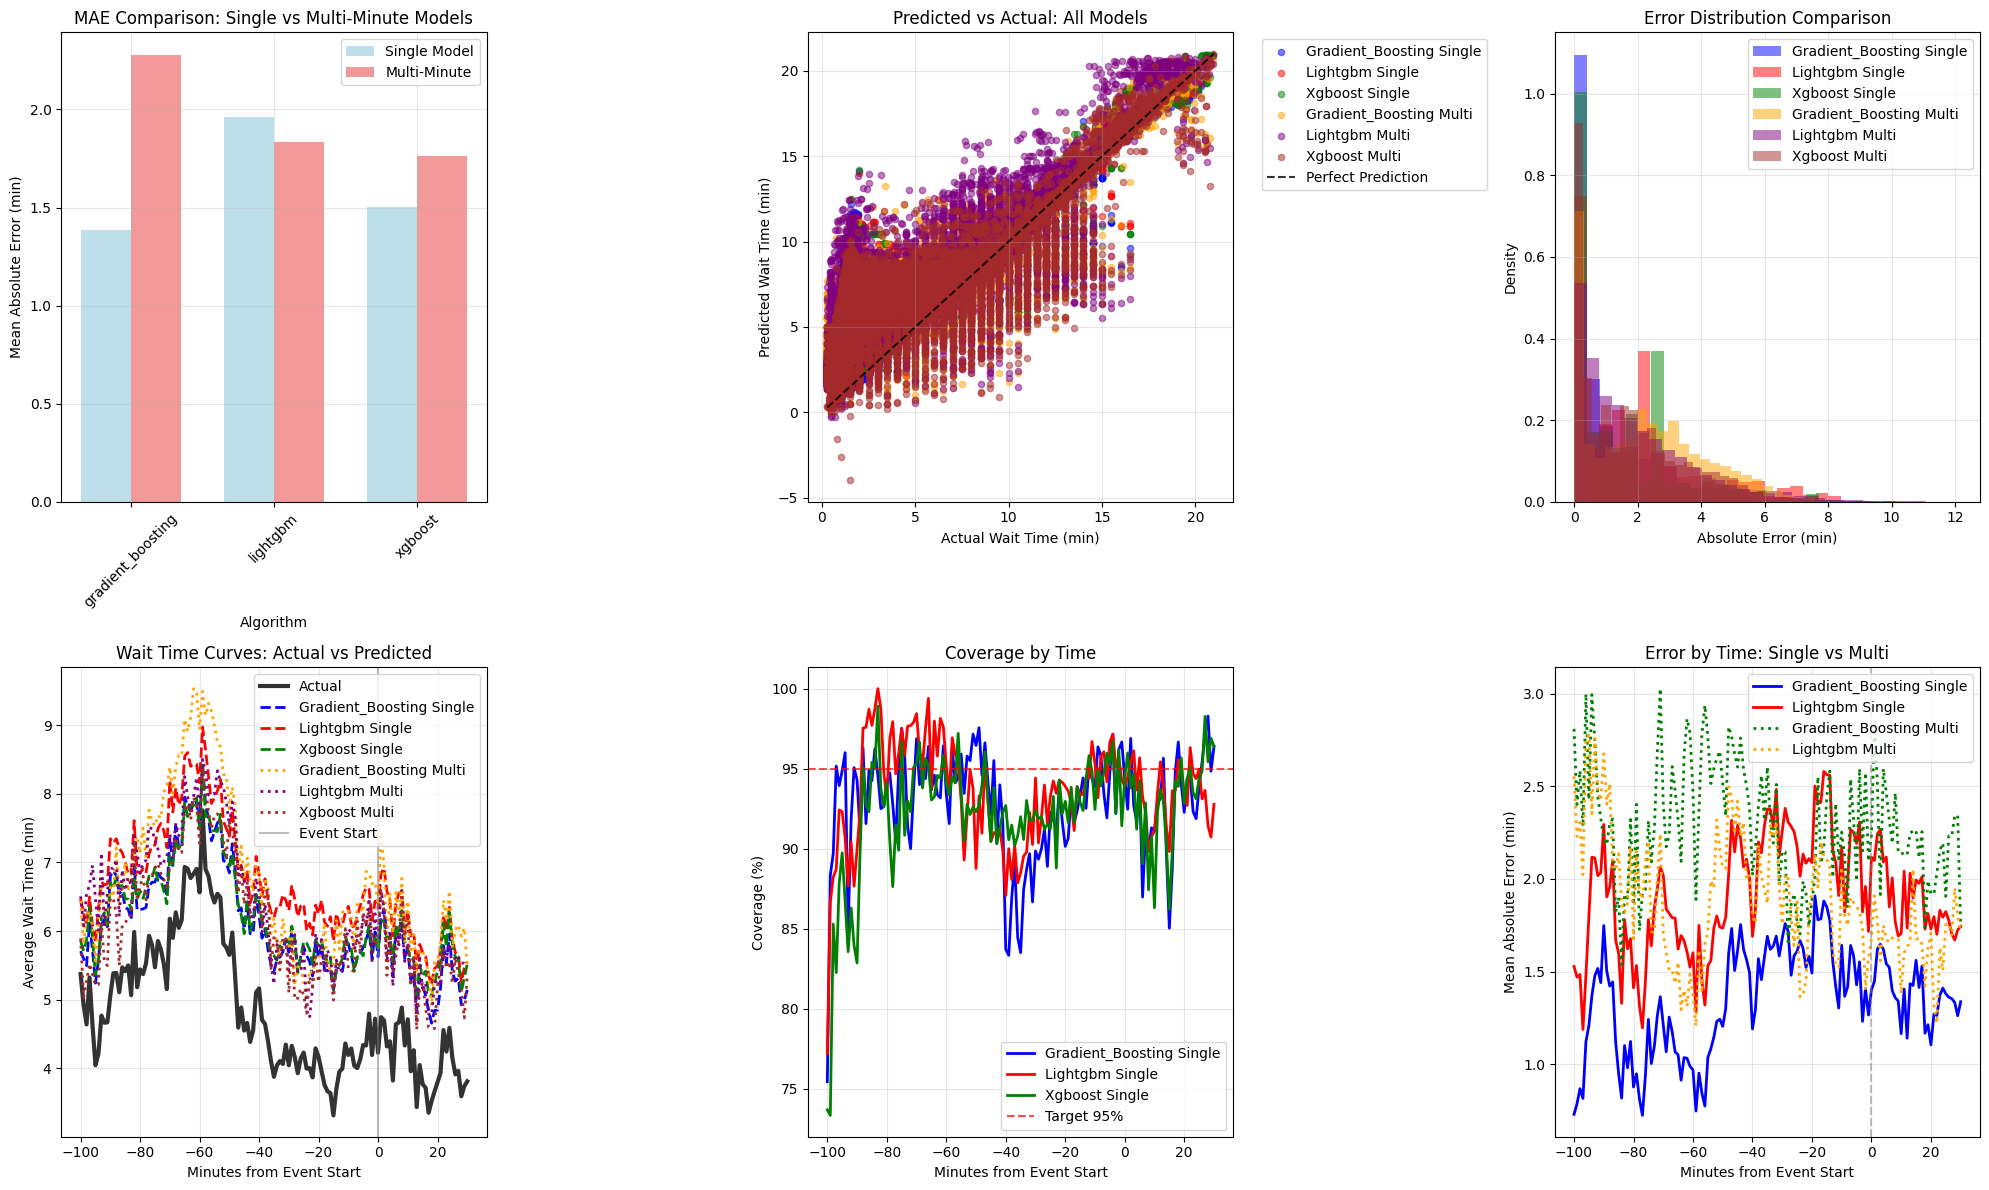

In [ ]:
if 'single_predictions' in locals() and 'multi_predictions' in locals():

    # Set up the plotting
    plt.style.use('default')
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

    # Create comprehensive evaluation plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. Model Performance Comparison (Bar Chart)
    ax = axes[0, 0]
    if 'metrics_df' in locals():
        metrics_pivot = metrics_df.pivot_table(
            index='algorithm',
            columns='approach',
            values=['mae', 'coverage', 'pinball']
        )

        # Plot MAE comparison
        mae_data = metrics_pivot['mae']
        x = np.arange(len(mae_data.index))
        width = 0.35

        if 'single' in mae_data.columns and 'multi' in mae_data.columns:
            ax.bar(x - width/2, mae_data['single'], width, label='Single Model', alpha=0.8, color='lightblue')
            ax.bar(x + width/2, mae_data['multi'], width, label='Multi-Minute', alpha=0.8, color='lightcoral')

        ax.set_xlabel('Algorithm')
        ax.set_ylabel('Mean Absolute Error (min)')
        ax.set_title('MAE Comparison: Single vs Multi-Minute Models')
        ax.set_xticks(x)
        ax.set_xticklabels(mae_data.index, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

    # 2. Prediction vs Actual Scatter Plot
    ax = axes[0, 1]

    # Combine all predictions for scatter plot
    all_model_names = list(single_predictions.keys()) + [f"{k}_multi" for k in multi_predictions.keys()]

    for i, model_name in enumerate(all_model_names[:6]):  # Limit to 6 models for readability
        if '_multi' in model_name:
            base_name = model_name.replace('_multi', '')
            if base_name in multi_predictions:
                y_pred = multi_predictions[base_name]
                label = f"{base_name.title()} Multi"
        else:
            if model_name in single_predictions:
                y_pred = single_predictions[model_name]
                label = f"{model_name.title()} Single"
            else:
                continue

        valid_mask = ~np.isnan(y_pred)
        if valid_mask.sum() > 0:
            ax.scatter(y_test[valid_mask], y_pred[valid_mask],
                      alpha=0.5, s=20, label=label, color=colors[i % len(colors)])

    # Perfect prediction line
    min_val = min(y_test.min(), min([pred.min() for pred in single_predictions.values() if len(pred) > 0]))
    max_val = max(y_test.max(), max([pred.max() for pred in single_predictions.values() if len(pred) > 0]))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect Prediction')

    ax.set_xlabel('Actual Wait Time (min)')
    ax.set_ylabel('Predicted Wait Time (min)')
    ax.set_title('Predicted vs Actual: All Models')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    # 3. Error Distribution
    ax = axes[0, 2]

    for i, (model_name, pred) in enumerate(single_predictions.items()):
        if i < 3:  # Limit to first 3 models
            valid_mask = ~np.isnan(pred)
            if valid_mask.sum() > 0:
                errors = np.abs(y_test[valid_mask] - pred[valid_mask])
                ax.hist(errors, bins=30, alpha=0.5, label=f'{model_name.title()} Single',
                       density=True, color=colors[i])

    for i, (model_name, pred) in enumerate(multi_predictions.items()):
        if i < 3:  # Limit to first 3 models
            valid_mask = ~np.isnan(pred)
            if valid_mask.sum() > 0:
                errors = np.abs(y_test[valid_mask] - pred[valid_mask])
                ax.hist(errors, bins=30, alpha=0.5, label=f'{model_name.title()} Multi',
                       density=True, color=colors[i+3])

    ax.set_xlabel('Absolute Error (min)')
    ax.set_ylabel('Density')
    ax.set_title('Error Distribution Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Wait Time Curves by Model
    ax = axes[1, 0]

    if 'curve_df' in locals() and not curve_df.empty:
        # Plot actual curve
        ax.plot(curve_df['minute'], curve_df['actual'], 'k-',
               linewidth=3, label='Actual', alpha=0.8)

        # Plot model curves
        model_count = 0
        for model_name in single_predictions.keys():
            col_name = f'{model_name}_single'
            if col_name in curve_df.columns and model_count < 3:
                ax.plot(curve_df['minute'], curve_df[col_name],
                       '--', linewidth=2, label=f'{model_name.title()} Single',
                       color=colors[model_count])
                model_count += 1

        for model_name in multi_predictions.keys():
            col_name = f'{model_name}_multi'
            if col_name in curve_df.columns and model_count < 6:
                ax.plot(curve_df['minute'], curve_df[col_name],
                       ':', linewidth=2, label=f'{model_name.title()} Multi',
                       color=colors[model_count])
                model_count += 1

        ax.axvline(0, color='gray', linestyle='-', alpha=0.5, label='Event Start')
        ax.set_xlabel('Minutes from Event Start')
        ax.set_ylabel('Average Wait Time (min)')
        ax.set_title('Wait Time Curves: Actual vs Predicted')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # 5. Coverage by Time
    ax = axes[1, 1]

    if 'curve_df' in locals() and not curve_df.empty:
        for i, model_name in enumerate(list(single_predictions.keys())[:3]):  # First 3 models
            coverage_by_time = []
            for minute in curve_df['minute']:
                minute_mask = df_test['relative start (minutes)'] == minute
                if minute_mask.sum() > 0:
                    y_true_minute = y_test[minute_mask]
                    y_pred_minute = single_predictions[model_name][minute_mask]
                    valid_pred_mask = ~np.isnan(y_pred_minute)

                    if valid_pred_mask.sum() > 0:
                        coverage = np.mean(y_true_minute[valid_pred_mask] <=
                                         y_pred_minute[valid_pred_mask]) * 100
                        coverage_by_time.append(coverage)
                    else:
                        coverage_by_time.append(np.nan)
                else:
                    coverage_by_time.append(np.nan)

            ax.plot(curve_df['minute'], coverage_by_time,
                   label=f'{model_name.title()} Single', linewidth=2,
                   color=colors[i])

        ax.axhline(95, color='red', linestyle='--', alpha=0.7, label='Target 95%')
        ax.set_xlabel('Minutes from Event Start')
        ax.set_ylabel('Coverage (%)')
        ax.set_title('Coverage by Time')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # 6. Error by Time
    ax = axes[1, 2]

    if 'curve_df' in locals() and not curve_df.empty:
        for i, model_name in enumerate(list(single_predictions.keys())[:2]):  # First 2 models
            error_by_time = []
            for minute in curve_df['minute']:
                minute_mask = df_test['relative start (minutes)'] == minute
                if minute_mask.sum() > 0:
                    y_true_minute = y_test[minute_mask]
                    y_pred_minute = single_predictions[model_name][minute_mask]
                    valid_pred_mask = ~np.isnan(y_pred_minute)

                    if valid_pred_mask.sum() > 0:
                        error = np.mean(np.abs(y_true_minute[valid_pred_mask] -
                                             y_pred_minute[valid_pred_mask]))
                        error_by_time.append(error)
                    else:
                        error_by_time.append(np.nan)
                else:
                    error_by_time.append(np.nan)

            ax.plot(curve_df['minute'], error_by_time,
                   label=f'{model_name.title()} Single', linewidth=2,
                   color=colors[i])

        # Add multi-minute model errors
        for i, model_name in enumerate(list(multi_predictions.keys())[:2]):  # First 2 models
            error_by_time = []
            for minute in curve_df['minute']:
                minute_mask = df_test['relative start (minutes)'] == minute
                if minute_mask.sum() > 0:
                    y_true_minute = y_test[minute_mask]
                    y_pred_minute = multi_predictions[model_name][minute_mask]
                    valid_pred_mask = ~np.isnan(y_pred_minute)

                    if valid_pred_mask.sum() > 0:
                        error = np.mean(np.abs(y_true_minute[valid_pred_mask] -
                                             y_pred_minute[valid_pred_mask]))
                        error_by_time.append(error)
                    else:
                        error_by_time.append(np.nan)
                else:
                    error_by_time.append(np.nan)

            ax.plot(curve_df['minute'], error_by_time,
                   ':', label=f'{model_name.title()} Multi', linewidth=2,
                   color=colors[i+2])

        ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
        ax.set_xlabel('Minutes from Event Start')
        ax.set_ylabel('Mean Absolute Error (min)')
        ax.set_title('Error by Time: Single vs Multi')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Confidence Interval

In [ ]:
import seaborn as sns
from scipy import stats



In [ ]:
if 'single_predictions' in locals() and 'multi_predictions' in locals():

   def calculate_confidence_intervals(y_true, y_pred, model_name, confidence_level=0.95):
       """Calculate confidence intervals for predictions and errors"""
       # Remove NaN predictions
       valid_mask = ~np.isnan(y_pred)
       y_true_clean = y_true[valid_mask]
       y_pred_clean = y_pred[valid_mask]

       if len(y_true_clean) == 0:
           return {}

       # Calculate errors
       errors = y_pred_clean - y_true_clean
       abs_errors = np.abs(errors)

       # Confidence intervals for predictions
       pred_mean = np.mean(y_pred_clean)
       pred_std = np.std(y_pred_clean)
       pred_se = pred_std / np.sqrt(len(y_pred_clean))

       # Confidence intervals for actual values
       actual_mean = np.mean(y_true_clean)
       actual_std = np.std(y_true_clean)
       actual_se = actual_std / np.sqrt(len(y_true_clean))

       # Confidence intervals for errors
       error_mean = np.mean(errors)
       error_std = np.std(errors)
       error_se = error_std / np.sqrt(len(errors))

       abs_error_mean = np.mean(abs_errors)
       abs_error_std = np.std(abs_errors)
       abs_error_se = abs_error_std / np.sqrt(len(abs_errors))

       # Calculate confidence intervals using t-distribution
       alpha = 1 - confidence_level
       dof = len(y_pred_clean) - 1
       t_critical = stats.t.ppf(1 - alpha/2, dof)

       return {
           'model': model_name,
           'n_samples': len(y_pred_clean),
           'confidence_level': confidence_level,

           # Predictions
           'pred_mean': pred_mean,
           'pred_ci_lower': pred_mean - t_critical * pred_se,
           'pred_ci_upper': pred_mean + t_critical * pred_se,
           'pred_std': pred_std,

           # Actual values
           'actual_mean': actual_mean,
           'actual_ci_lower': actual_mean - t_critical * actual_se,
           'actual_ci_upper': actual_mean + t_critical * actual_se,
           'actual_std': actual_std,

           # Errors
           'error_mean': error_mean,
           'error_ci_lower': error_mean - t_critical * error_se,
           'error_ci_upper': error_mean + t_critical * error_se,

           # Absolute errors
           'abs_error_mean': abs_error_mean,
           'abs_error_ci_lower': abs_error_mean - t_critical * abs_error_se,
           'abs_error_ci_upper': abs_error_mean + t_critical * abs_error_se,

           # Error percentiles
           'error_p25': np.percentile(abs_errors, 25),
           'error_p50': np.percentile(abs_errors, 50),
           'error_p75': np.percentile(abs_errors, 75),
           'error_p90': np.percentile(abs_errors, 90),
           'error_p95': np.percentile(abs_errors, 95)
       }

   # Calculate confidence intervals for all models
   confidence_results = []

   # Single models
   for model_name, pred in single_predictions.items():
       ci_results = calculate_confidence_intervals(y_test, pred, f"{model_name}_single")
       confidence_results.append(ci_results)

       print(f"\n {model_name.title()} Single Model - 95% Confidence Intervals:")
       print(f"  Predicted Wait Time: {ci_results['pred_mean']:.2f} ± {(ci_results['pred_ci_upper'] - ci_results['pred_mean']):.2f} min")
       print(f"  Actual Wait Time:    {ci_results['actual_mean']:.2f} ± {(ci_results['actual_ci_upper'] - ci_results['actual_mean']):.2f} min")
       print(f"  Absolute Error:      {ci_results['abs_error_mean']:.2f} ± {(ci_results['abs_error_ci_upper'] - ci_results['abs_error_mean']):.2f} min")
       print(f"  Error Percentiles:   P50={ci_results['error_p50']:.2f}, P90={ci_results['error_p90']:.2f}, P95={ci_results['error_p95']:.2f}")

   # Multi models
   for model_name, pred in multi_predictions.items():
       ci_results = calculate_confidence_intervals(y_test, pred, f"{model_name}_multi")
       confidence_results.append(ci_results)

       print(f"\n {model_name.title()} Multi Model - 95% Confidence Intervals:")
       print(f"  Predicted Wait Time: {ci_results['pred_mean']:.2f} ± {(ci_results['pred_ci_upper'] - ci_results['pred_mean']):.2f} min")
       print(f"  Actual Wait Time:    {ci_results['actual_mean']:.2f} ± {(ci_results['actual_ci_upper'] - ci_results['actual_mean']):.2f} min")
       print(f"  Absolute Error:      {ci_results['abs_error_mean']:.2f} ± {(ci_results['abs_error_ci_upper'] - ci_results['abs_error_mean']):.2f} min")
       print(f"  Error Percentiles:   P50={ci_results['error_p50']:.2f}, P90={ci_results['error_p90']:.2f}, P95={ci_results['error_p95']:.2f}")

   # Create comprehensive seaborn visualization
   print("\n Creating confidence interval visualizations with seaborn...")

   # Set up seaborn style
   sns.set_style("whitegrid")
   plt.style.use('default')
   fig, axes = plt.subplots(2, 3, figsize=(20, 12))

   # 1. Error Distribution with Confidence Intervals (Seaborn Boxplot)
   ax = axes[0, 0]
   error_data = []

   for model_name, pred in single_predictions.items():
       valid_mask = ~np.isnan(pred)
       if valid_mask.sum() > 0:
           errors = np.abs(y_test[valid_mask] - pred[valid_mask])
           error_data.extend([{'Model': f'{model_name.title()} Single', 'Error': e} for e in errors])

   for model_name, pred in multi_predictions.items():
       valid_mask = ~np.isnan(pred)
       if valid_mask.sum() > 0:
           errors = np.abs(y_test[valid_mask] - pred[valid_mask])
           error_data.extend([{'Model': f'{model_name.title()} Multi', 'Error': e} for e in errors])

   error_df = pd.DataFrame(error_data)
   sns.boxplot(data=error_df, x='Model', y='Error', ax=ax, palette='Set2')
   ax.set_title('Error Distribution with Confidence Intervals')
   ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
   ax.set_ylabel('Absolute Error (min)')

   # 2. Prediction vs Actual with Confidence Bands (Seaborn)
   ax = axes[0, 1]

   # Combine all predictions for overall view
   all_actual = []
   all_predicted = []
   all_models = []

   for model_name, pred in single_predictions.items():
       valid_mask = ~np.isnan(pred)
       if valid_mask.sum() > 0:
           all_actual.extend(y_test[valid_mask])
           all_predicted.extend(pred[valid_mask])
           all_models.extend([f'{model_name.title()} Single'] * valid_mask.sum())

   for model_name, pred in multi_predictions.items():
       valid_mask = ~np.isnan(pred)
       if valid_mask.sum() > 0:
           all_actual.extend(y_test[valid_mask])
           all_predicted.extend(pred[valid_mask])
           all_models.extend([f'{model_name.title()} Multi'] * valid_mask.sum())

   pred_actual_df = pd.DataFrame({
       'Actual': all_actual,
       'Predicted': all_predicted,
       'Model': all_models
   })

   sns.scatterplot(data=pred_actual_df, x='Actual', y='Predicted', hue='Model',
                  alpha=0.6, ax=ax, s=30)

   # Add perfect prediction line
   min_val = min(pred_actual_df['Actual'].min(), pred_actual_df['Predicted'].min())
   max_val = max(pred_actual_df['Actual'].max(), pred_actual_df['Predicted'].max())
   ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, linewidth=2)

   ax.set_title('Predicted vs Actual with Model Comparison')
   ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

   # 3. Confidence Interval Comparison
   ax = axes[0, 2]
   ci_comparison_data = []

   for ci_result in confidence_results:
       ci_comparison_data.append({
           'Model': ci_result['model'].replace('_', ' ').title(),
           'Metric': 'Prediction Mean',
           'Value': ci_result['pred_mean'],
           'CI_Lower': ci_result['pred_ci_lower'],
           'CI_Upper': ci_result['pred_ci_upper']
       })
       ci_comparison_data.append({
           'Model': ci_result['model'].replace('_', ' ').title(),
           'Metric': 'Error Mean',
           'Value': ci_result['abs_error_mean'],
           'CI_Lower': ci_result['abs_error_ci_lower'],
           'CI_Upper': ci_result['abs_error_ci_upper']
       })

   ci_df = pd.DataFrame(ci_comparison_data)

   # Plot confidence intervals
   models = [ci_result['model'] for ci_result in confidence_results]
   x_pos = np.arange(len(models))

   pred_means = [ci_result['pred_mean'] for ci_result in confidence_results]
   pred_errors = [[ci_result['pred_mean'] - ci_result['pred_ci_lower'] for ci_result in confidence_results],
                  [ci_result['pred_ci_upper'] - ci_result['pred_mean'] for ci_result in confidence_results]]

   error_means = [ci_result['abs_error_mean'] for ci_result in confidence_results]
   error_errors = [[ci_result['abs_error_mean'] - ci_result['abs_error_ci_lower'] for ci_result in confidence_results],
                   [ci_result['abs_error_ci_upper'] - ci_result['abs_error_mean'] for ci_result in confidence_results]]

   ax.errorbar(x_pos - 0.1, pred_means, yerr=pred_errors,
               fmt='o', capsize=5, label='Prediction Mean ± CI', markersize=8, color='blue')

   ax.errorbar(x_pos + 0.1, error_means, yerr=error_errors,
               fmt='s', capsize=5, label='Error Mean ± CI', markersize=8, color='red')

   ax.set_xticks(x_pos)
   ax.set_xticklabels([m.replace('_', ' ').title() for m in models], rotation=45)
   ax.set_ylabel('Wait Time (min)')
   ax.set_title('Model Confidence Intervals')
   ax.legend()
   ax.grid(True, alpha=0.3)

   # 4. Error percentile analysis (Seaborn)
   ax = axes[1, 0]
   percentile_data = []

   for ci_result in confidence_results:
       model_clean = ci_result['model'].replace('_', ' ').title()
       percentile_data.extend([
           {'Model': model_clean, 'Percentile': 'P50', 'Error': ci_result['error_p50']},
           {'Model': model_clean, 'Percentile': 'P75', 'Error': ci_result['error_p75']},
           {'Model': model_clean, 'Percentile': 'P90', 'Error': ci_result['error_p90']},
           {'Model': model_clean, 'Percentile': 'P95', 'Error': ci_result['error_p95']}
       ])

   percentile_df = pd.DataFrame(percentile_data)
   sns.barplot(data=percentile_df, x='Model', y='Error', hue='Percentile', ax=ax, palette='viridis')
   ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
   ax.set_ylabel('Error (min)')
   ax.set_title('Error Percentiles by Model')
   ax.legend()

   # 5. Time-based confidence intervals
   ax = axes[1, 1]

   # Calculate time-based confidence intervals for best model
   if 'gradient_boosting' in single_predictions:
       time_ci_data = []

       for minute in sorted(df_test['relative start (minutes)'].unique())[::3]:  # Every 3rd minute
           minute_data = df_test[df_test['relative start (minutes)'] == minute]

           if len(minute_data) >= 5:  # Minimum samples for CI calculation
               actual_values = minute_data[target].values
               pred_subset = single_predictions['gradient_boosting'][df_test['relative start (minutes)'] == minute]
               valid_pred_mask = ~np.isnan(pred_subset)

               if valid_pred_mask.sum() >= 5:
                   actual_clean = actual_values[valid_pred_mask]
                   pred_clean = pred_subset[valid_pred_mask]

                   # Calculate means and confidence intervals
                   actual_mean = np.mean(actual_clean)
                   pred_mean = np.mean(pred_clean)

                   actual_se = np.std(actual_clean) / np.sqrt(len(actual_clean))
                   pred_se = np.std(pred_clean) / np.sqrt(len(pred_clean))

                   t_critical = stats.t.ppf(0.975, len(actual_clean) - 1)

                   time_ci_data.append({
                       'minute': minute,
                       'actual_mean': actual_mean,
                       'actual_ci_lower': actual_mean - t_critical * actual_se,
                       'actual_ci_upper': actual_mean + t_critical * actual_se,
                       'pred_mean': pred_mean,
                       'pred_ci_lower': pred_mean - t_critical * pred_se,
                       'pred_ci_upper': pred_mean + t_critical * pred_se
                   })

       if time_ci_data:
           time_ci_df = pd.DataFrame(time_ci_data)

           ax.plot(time_ci_df['minute'], time_ci_df['actual_mean'], 'b-', linewidth=3, label='Actual Mean')
           ax.fill_between(time_ci_df['minute'], time_ci_df['actual_ci_lower'], time_ci_df['actual_ci_upper'],
                          alpha=0.3, color='blue', label='Actual 95% CI')

           ax.plot(time_ci_df['minute'], time_ci_df['pred_mean'], 'r-', linewidth=3, label='Predicted Mean')
           ax.fill_between(time_ci_df['minute'], time_ci_df['pred_ci_lower'], time_ci_df['pred_ci_upper'],
                          alpha=0.3, color='red', label='Predicted 95% CI')

           ax.axvline(0, color='gray', linestyle=':', alpha=0.7)
           ax.set_xlabel('Minutes from Event Start')
           ax.set_ylabel('Wait Time (min)')
           ax.set_title('Time-based Confidence Intervals')
           ax.legend()
           ax.grid(True, alpha=0.3)

   # 6. Model reliability heatmap (Seaborn)
   ax = axes[1, 2]

   reliability_data = []
   for ci_result in confidence_results:
       model_clean = ci_result['model'].replace('_', ' ').title()

       # Calculate various reliability metrics
       pred_ci_width = ci_result['pred_ci_upper'] - ci_result['pred_ci_lower']
       error_ci_width = ci_result['abs_error_ci_upper'] - ci_result['abs_error_ci_lower']

       reliability_data.append({
           'Model': model_clean,
           'Prediction_Stability': 100 / (1 + pred_ci_width),
           'Error_Consistency': 100 / (1 + error_ci_width),
           'P90_Performance': 100 / (1 + ci_result['error_p90']),
           'Sample_Size_Score': min(100, ci_result['n_samples'] / 10)
       })

   reliability_df = pd.DataFrame(reliability_data)
   reliability_df = reliability_df.set_index('Model')

   sns.heatmap(reliability_df, annot=True, fmt='.1f', cmap='RdYlGn',
               ax=ax, cbar_kws={'label': 'Score (Higher = Better)'})
   ax.set_title('Model Reliability Heatmap')
   ax.set_xlabel('')

   plt.tight_layout()
   plt.show()

   # Summary statistics table
   print("\n📊 Confidence Interval Summary Table:")
   print("=" * 80)

   summary_data = []
   for ci_result in confidence_results:
       summary_data.append({
           'Model': ci_result['model'],
           'Pred_Mean': ci_result['pred_mean'],
           'Pred_CI_Width': ci_result['pred_ci_upper'] - ci_result['pred_ci_lower'],
           'Error_Mean': ci_result['abs_error_mean'],
           'Error_CI_Width': ci_result['abs_error_ci_upper'] - ci_result['abs_error_ci_lower'],
           'P50_Error': ci_result['error_p50'],
           'P90_Error': ci_result['error_p90'],
           'P95_Error': ci_result['error_p95']
       })

   summary_df = pd.DataFrame(summary_data)
   print(summary_df.round(2))

   # Key insights
   print(f"\n💡 Key Confidence Interval Insights:")
   print("-" * 40)

   best_p90 = min(confidence_results, key=lambda x: x['error_p90'])
   narrowest_error_ci = min(confidence_results, key=lambda x: x['abs_error_ci_upper'] - x['abs_error_ci_lower'])

   print(f"Best P90 Performance: {best_p90['model']} (90% errors ≤ {best_p90['error_p90']:.2f} min)")
   print(f"Most Consistent:      {narrowest_error_ci['model']} (±{(narrowest_error_ci['abs_error_ci_upper'] - narrowest_error_ci['abs_error_mean']):.2f} min)")

   # Error frequency analysis
   print(f"\n📈 Error Frequency Analysis:")
   print("-" * 30)
   for ci_result in confidence_results:
       model_name = ci_result['model']
       print(f"\n{model_name}:")
       print(f"  50% of errors ≤ {ci_result['error_p50']:.2f} minutes")
       print(f"  90% of errors ≤ {ci_result['error_p90']:.2f} minutes")
       print(f"  95% of errors ≤ {ci_result['error_p95']:.2f} minutes")

       # Practical interpretation
       if ci_result['error_p90'] < 5:
           reliability_text = "🟢 Very Reliable"
       elif ci_result['error_p90'] < 10:
           reliability_text = "🟡 Reliable"
       else:
           reliability_text = "🔴 Needs Improvement"

       print(f"  → {reliability_text}")

print(f"\n✅ Confidence interval analysis complete!")


✅ Confidence interval analysis complete!


### Feature Importance

📊 Feature Importance Rankings:
----------------------------------------

GRADIENT_BOOSTING Single Model - Top 15 Features:
  num__numberinline_log                             : 0.9109
  num__log_queue_max10                              : 0.0353
  cat__team_Joker Xue                               : 0.0163
  num__count                                        : 0.0061
  cat__team_Travis Scott                            : 0.0060
  cat__team_Twenty One Pilots                       : 0.0057
  num__relative start (minutes)                     : 0.0041
  num__queue_slope_3                                : 0.0013
  cat__team_The Love Hard Tour                      : 0.0012
  cat__team_Tyler, The Creator                      : 0.0010
  cat__team_Rauw Alejandro                          : 0.0010
  cat__team_Lil Uzi Vert                            : 0.0009
  cat__team_Wu-Tang & Nas                           : 0.0009
  cat__team_4 Legends, One Stage                    : 0.0008
  cat__time category_30

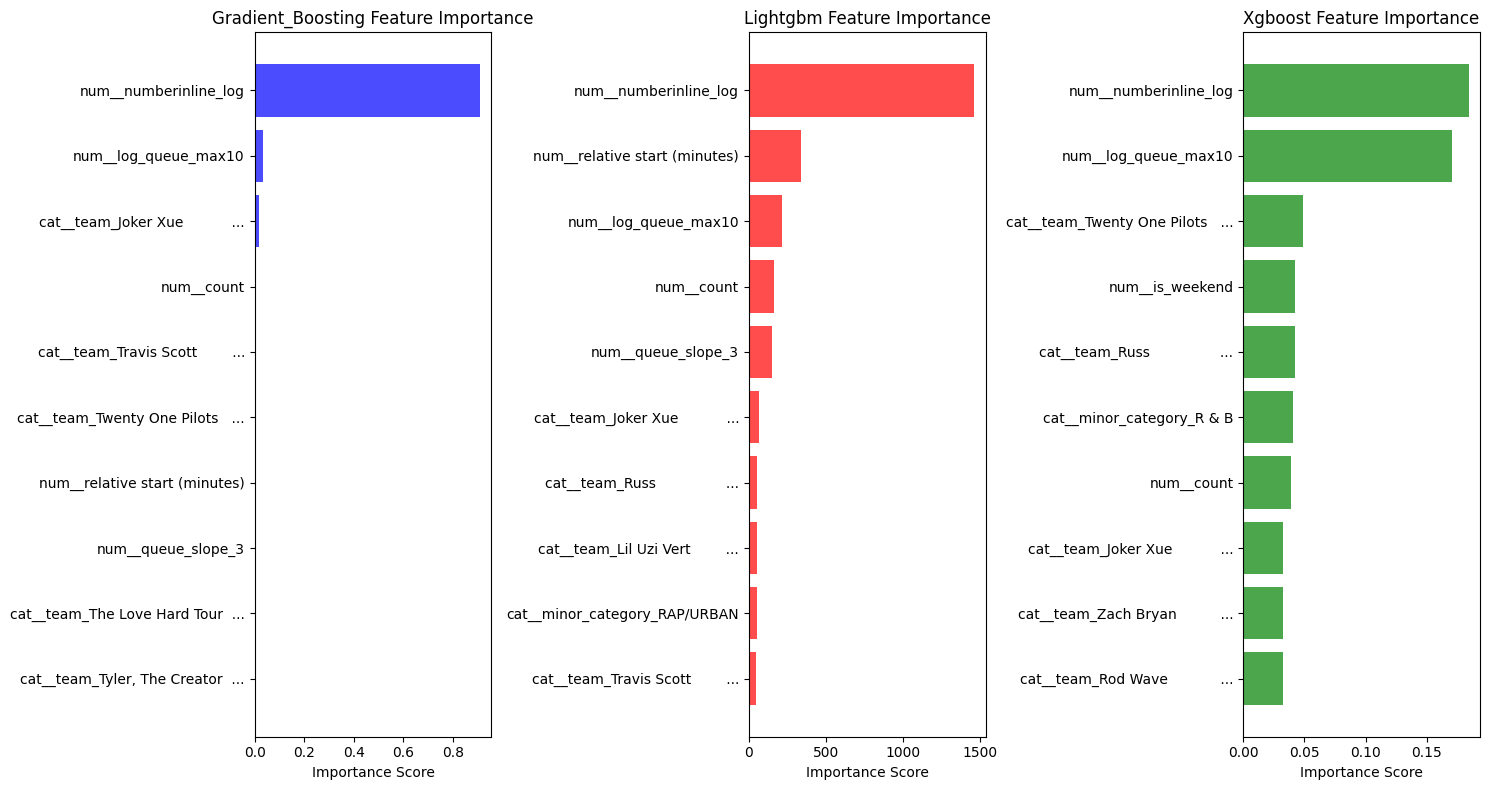

In [ ]:
if 'single_models' in locals():

    print("📊 Feature Importance Rankings:")
    print("-" * 40)

    for model_name, model in single_models.items():
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_

            # Create importance DataFrame
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importance
            }).sort_values('importance', ascending=False)

            print(f"\n{model_name.upper()} Single Model - Top 15 Features:")
            for idx, row in importance_df.head(15).iterrows():
                print(f"  {row['feature']:50s}: {row['importance']:.4f}")

    # Feature importance visualization
    plt.figure(figsize=(15, 8))

    model_count = 0
    for model_name, model in single_models.items():
        if hasattr(model, 'feature_importances_') and model_count < 3:
            importance = model.feature_importances_
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importance
            }).sort_values('importance', ascending=False)

            # Plot top 10 features
            top_features = importance_df.head(10)

            plt.subplot(1, min(3, len(single_models)), model_count + 1)
            plt.barh(range(len(top_features)), top_features['importance'],
                    color=colors[model_count % len(colors)], alpha=0.7)
            plt.yticks(range(len(top_features)),
                      [f[:30] + '...' if len(f) > 30 else f for f in top_features['feature']])
            plt.xlabel('Importance Score')
            plt.title(f'{model_name.title()} Feature Importance')
            plt.gca().invert_yaxis()

            model_count += 1

    plt.tight_layout()
    plt.show()

### Summary

In [ ]:
if 'metrics_df' in locals():

    # Find best model by different criteria
    best_mae = metrics_df.loc[metrics_df['mae'].idxmin()]
    best_coverage = metrics_df.loc[metrics_df['coverage'].idxmax()]
    best_pinball = metrics_df.loc[metrics_df['pinball'].idxmin()]

    print(f"Best MAE:          {best_mae['model']:25s} ({best_mae['mae']:.2f} min)")
    print(f"Best Coverage:     {best_coverage['model']:25s} ({best_coverage['coverage']:.1f}%)")
    print(f"Best Pinball Loss: {best_pinball['model']:25s} ({best_pinball['pinball']:.4f})")

    # Overall ranking (composite score)
    metrics_df['composite_score'] = (
        metrics_df['mae'].rank() +
        metrics_df['pinball'].rank() +
        (100 - metrics_df['coverage']).rank()
    )

    best_overall = metrics_df.loc[metrics_df['composite_score'].idxmin()]

    print(f"MAE: {best_overall['mae']:.2f} minutes")
    print(f"Coverage: {best_overall['coverage']:.1f}%")
    print(f"Pinball Loss: {best_overall['pinball']:.4f}")
    print(f"Over-Prediction Rate: {best_overall['over_pred_rate']:.1f}%")

    # Approach comparison
    single_avg_mae = metrics_df[metrics_df['approach'] == 'single']['mae'].mean()
    multi_avg_mae = metrics_df[metrics_df['approach'] == 'multi']['mae'].mean()

    print(f"Single Model Average MAE:  {single_avg_mae:.2f} min")
    print(f"Multi-Minute Average MAE:  {multi_avg_mae:.2f} min")
    print(f"Difference:                {abs(single_avg_mae - multi_avg_mae):.2f} min")

    if single_avg_mae < multi_avg_mae:
        print("Single model approach performs better on average")
    else:
        print("Multi-minute approach performs better on average")

    # Production readiness assessment
    print(f"\n PRODUCTION READINESS ASSESSMENT:")
    print("-" * 40)

    checks = {
        'mae_acceptable': best_overall['mae'] < 10.0,
        'coverage_adequate': best_overall['coverage'] > 90.0,
        'pinball_reasonable': best_overall['pinball'] < 5.0,
        'sufficient_test_data': len(y_test) > 100,
        'model_diversity': len(metrics_df) > 1
    }

    for check, passed in checks.items():
        status = "ok" if passed else "not ok"
        print(f"{check:25s}: {status}")

    overall_ready = all(checks.values())
    status = "ok" if overall_ready else "not ok"
    print(f"\nOverall Status: {status}")

Best MAE:          gradient_boosting_single  (1.38 min)
Best Coverage:     lightgbm_single           (93.6%)
Best Pinball Loss: gradient_boosting_single  (0.0899)
MAE: 1.38 minutes
Coverage: 92.8%
Pinball Loss: 0.0899
Over-Prediction Rate: 92.8%
Single Model Average MAE:  1.62 min
Multi-Minute Average MAE:  1.96 min
Difference:                0.34 min
Single model approach performs better on average

 PRODUCTION READINESS ASSESSMENT:
----------------------------------------
mae_acceptable           : ok
coverage_adequate        : ok
pinball_reasonable       : ok
sufficient_test_data     : ok
model_diversity          : ok

Overall Status: ok


### SHAP

Analyzing SHAP values for best model: gradient_boosting
✅ Generated SHAP values using TreeExplainer


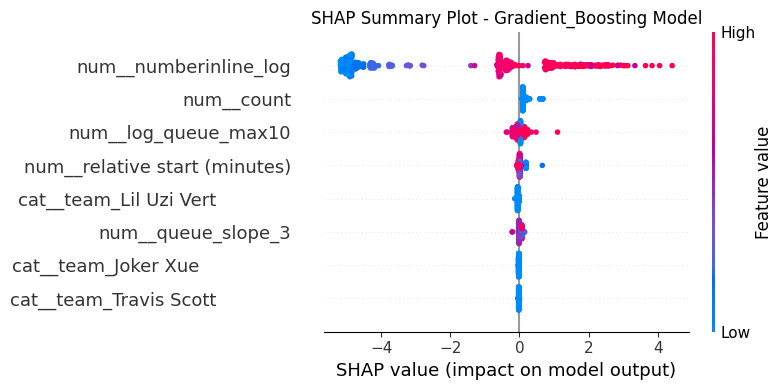

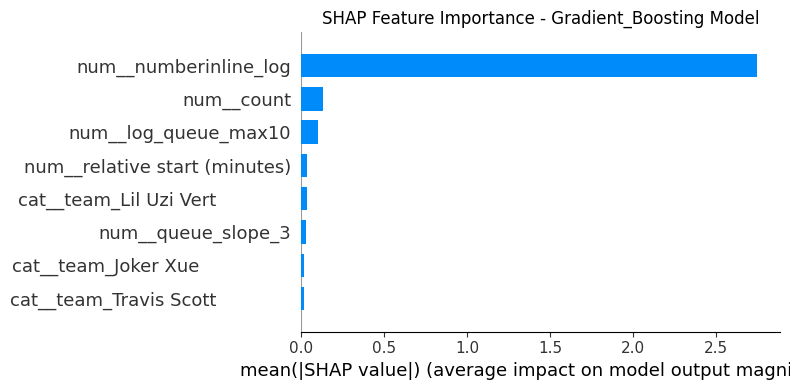

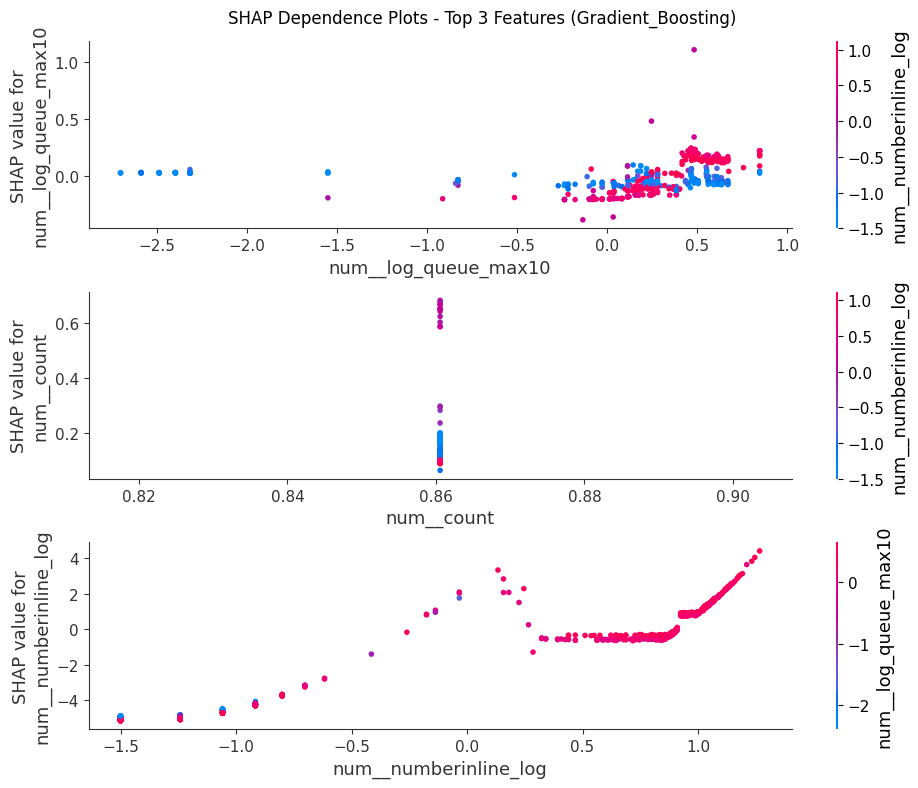


📊 SHAP Analysis by Time Period:
----------------------------------------

Pre-Event (-100 to -10 min):
  Sample size: 500 predictions
  Top 5 Features:
    num__numberinline_log                   : 2.7470
    num__count                              : 0.1342
    num__log_queue_max10                    : 0.1037
    num__relative start (minutes)           : 0.0385
    cat__team_Lil Uzi Vert                  : 0.0373

💡 Key Business Insights from SHAP Analysis:
--------------------------------------------------
🔝 Top 5 Drivers of Wait Time Predictions:
  1. num__numberinline_log                        : 2.7470
  2. num__count                                   : 0.1342
  3. num__log_queue_max10                         : 0.1037
  4. num__relative start (minutes)                : 0.0385
  5. cat__team_Lil Uzi Vert                       : 0.0373

⏰ Temporal Features Average Importance: 0.0035
📊 Queue Dynamics Average Importance: 0.9615
🏟️ Venue Features Average Importance: 0.0001

 Prediction

In [ ]:
if 'single_models' in locals():

    # Select best performing model for detailed SHAP analysis
    if 'best_overall' in locals():
        best_model_name = best_overall['model'].replace('_single', '').replace('_multi', '')
        if best_model_name in single_models:
            best_model = single_models[best_model_name]
            print(f"Analyzing SHAP values for best model: {best_model_name}")
        else:
            # Fallback to first available model
            best_model_name = list(single_models.keys())[0]
            best_model = single_models[best_model_name]
            print(f"Analyzing SHAP values for: {best_model_name}")
    else:
        best_model_name = list(single_models.keys())[0]
        best_model = single_models[best_model_name]
        print(f"Analyzing SHAP values for: {best_model_name}")

    # Create SHAP explainer
    # Use a subset of training data for faster computation
    X_train_sample = X_train_dense[:min(1000, len(X_train_dense))]
    X_test_sample = X_test_dense[:min(500, len(X_test_dense))]

    try:
        # TreeExplainer for tree-based models (GB, LightGBM, XGBoost)
        if hasattr(best_model, 'estimators_') or 'lgb' in str(type(best_model)).lower() or 'xgb' in str(type(best_model)).lower():
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_test_sample)
            print(f"✅ Generated SHAP values using TreeExplainer")
        else:
            # KernelExplainer for other models (slower but universal)
            explainer = shap.KernelExplainer(best_model.predict, X_train_sample)
            shap_values = explainer.shap_values(X_test_sample)
            print(f"✅ Generated SHAP values using KernelExplainer")

        # Feature names for SHAP plots
        shap_feature_names = feature_names[:len(shap_values[0])] if len(feature_names) > len(shap_values[0]) else feature_names

        # 1. Summary Plot (Feature Importance + Impact Direction)
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test_sample, feature_names=shap_feature_names,
                           max_display=8,        # Show fewer features
                           plot_size=(8, 4),     # SHAP's internal size control
                           show=False)
        plt.title(f'SHAP Summary Plot - {best_model_name.title()} Model')
        plt.tight_layout()
        plt.show()

        # 2. Feature Importance Bar Plot
        plt.figure(figsize=(8, 4))
        shap.summary_plot(shap_values, X_test_sample, feature_names=shap_feature_names, plot_type="bar",
                           max_display=8,        # Show fewer features
                           plot_size=(8, 4),     # SHAP's internal size control
                           show=False)
        plt.title(f'SHAP Feature Importance - {best_model_name.title()} Model')
        plt.tight_layout()
        plt.show()

        # 3. Waterfall plot for worst prediction
        if 'error_diagnostics' in locals():
            # Find worst prediction case
            worst_idx = error_diagnostics['worst_error'].idxmax()
            worst_case_position = df_test.index.get_loc(worst_idx)

            if worst_case_position < len(X_test_sample):
                plt.figure(figsize=(10, 4))
                shap.waterfall_plot(
                    explainer.expected_value,
                    shap_values[worst_case_position],
                    X_test_sample[worst_case_position],
                    feature_names=shap_feature_names,
                    show=False
                )
                plt.title(f'SHAP Waterfall Plot - Worst Prediction Case\n'
                         f'Actual: {df_test.iloc[worst_case_position][target]:.1f} min, '
                         f'Predicted: {single_predictions[best_model_name][worst_case_position]:.1f} min')
                plt.tight_layout()
                plt.show()

        # 4. Dependence plots for top features
        # Get top 3 most important features
        feature_importance = np.abs(shap_values).mean(0)
        top_feature_indices = np.argsort(feature_importance)[-3:]

        fig, axes = plt.subplots(3, 1, figsize=(10, 8))
        for i, feature_idx in enumerate(top_feature_indices):
            shap.dependence_plot(
                feature_idx, shap_values, X_test_sample,
                feature_names=shap_feature_names,
                ax=axes[i], show=False
            )
        plt.suptitle(f'SHAP Dependence Plots - Top 3 Features ({best_model_name.title()})')
        plt.tight_layout()
        plt.show()

        # 5. SHAP analysis for specific time periods
        print("\n📊 SHAP Analysis by Time Period:")
        print("-" * 40)

        # Analyze pre-event, event start, and post-event periods
        time_periods = {
            'Pre-Event (-100 to -10 min)': (-100, -10),
            'Event Start (-10 to +10 min)': (-10, 10),
            'Post-Event (+10 to +30 min)': (10, 30)
        }

        for period_name, (start_time, end_time) in time_periods.items():
            period_mask = (df_test['relative start (minutes)'] >= start_time) & \
                         (df_test['relative start (minutes)'] <= end_time)

            if period_mask.sum() > 10:  # Ensure sufficient data
                period_indices = np.where(period_mask)[0]
                period_indices = period_indices[period_indices < len(X_test_sample)]

                if len(period_indices) > 0:
                    period_shap = shap_values[period_indices]
                    period_importance = np.abs(period_shap).mean(0)

                    # Top 5 features for this period
                    top_5_indices = np.argsort(period_importance)[-5:]

                    print(f"\n{period_name}:")
                    print(f"  Sample size: {len(period_indices)} predictions")
                    print("  Top 5 Features:")
                    for idx in reversed(top_5_indices):
                        feature_name = shap_feature_names[idx] if idx < len(shap_feature_names) else f"Feature_{idx}"
                        print(f"    {feature_name[:40]:40s}: {period_importance[idx]:.4f}")

        # 6. Business insights from SHAP
        print(f"\n💡 Key Business Insights from SHAP Analysis:")
        print("-" * 50)

        # Overall feature importance insights
        overall_importance = np.abs(shap_values).mean(0)
        top_5_overall = np.argsort(overall_importance)[-5:]

        print("🔝 Top 5 Drivers of Wait Time Predictions:")
        for i, idx in enumerate(reversed(top_5_overall)):
            feature_name = shap_feature_names[idx] if idx < len(shap_feature_names) else f"Feature_{idx}"
            importance_score = overall_importance[idx]
            print(f"  {i+1}. {feature_name[:45]:45s}: {importance_score:.4f}")

        # Feature category analysis
        temporal_features = [i for i, name in enumerate(shap_feature_names)
                           if any(temp in name.lower() for temp in ['hour', 'day', 'minute', 'weekend', 'holiday'])]
        queue_features = [i for i, name in enumerate(shap_feature_names)
                         if any(queue in name.lower() for queue in ['queue', 'numberinline', 'slope'])]
        venue_features = [i for i, name in enumerate(shap_feature_names)
                         if any(venue in name.lower() for venue in ['property', 'tier', 'minor_category'])]

        if temporal_features:
            temporal_importance = np.mean([overall_importance[i] for i in temporal_features])
            print(f"\n⏰ Temporal Features Average Importance: {temporal_importance:.4f}")

        if queue_features:
            queue_importance = np.mean([overall_importance[i] for i in queue_features])
            print(f"📊 Queue Dynamics Average Importance: {queue_importance:.4f}")

        if venue_features:
            venue_importance = np.mean([overall_importance[i] for i in venue_features])
            print(f"🏟️ Venue Features Average Importance: {venue_importance:.4f}")

        # Prediction confidence analysis
        prediction_confidence = np.std(shap_values, axis=1)
        high_confidence_mask = prediction_confidence < np.percentile(prediction_confidence, 25)
        low_confidence_mask = prediction_confidence > np.percentile(prediction_confidence, 75)

        print(f"\n Prediction Confidence Analysis:")
        print(f"  High Confidence Predictions: {high_confidence_mask.sum()} ({high_confidence_mask.mean()*100:.1f}%)")
        print(f"  Low Confidence Predictions:  {low_confidence_mask.sum()} ({low_confidence_mask.mean()*100:.1f}%)")

        if high_confidence_mask.sum() > 0 and low_confidence_mask.sum() > 0:
            high_conf_error = np.abs(y_test[high_confidence_mask] -
                                   single_predictions[best_model_name][high_confidence_mask]).mean()
            low_conf_error = np.abs(y_test[low_confidence_mask] -
                                  single_predictions[best_model_name][low_confidence_mask]).mean()

            print(f"  High Confidence MAE: {high_conf_error:.2f} min")
            print(f"  Low Confidence MAE:  {low_conf_error:.2f} min")

    except Exception as e:
        print(f"❌ SHAP analysis failed: {e}")
        print("Consider reducing sample size or using a different explainer")